# Предсказание снижения покупательской активности
## Описание проекта
Прогноз строится на основе данных по продажам магазина из нескольких таблиц - поведение пользователей на сайте, данных о выручке, времени на сайте, среднемесячной прибыли с покупателя за последние 3 месяца. Прогноз снижения активности позволит выделить приоритетный сегмент потребителей и сделать персонализированные предложения.

## Задача
Разработать модель, которая предскажет вероятность снижения покупательской активности.

## Исходные данные
Данные для работы находятся в четырех файлах:
- market_file.csv - данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- market_money.csv - данные о выручке
- market_time.csv - данные о времени (в минутах), которое покупатель провёл на сайте
- money.csv - данные о среднемесячной прибыли за последние 3 месяца

## Загрузка данных
Но перед этим сделам импорт необходимых библиотек и проведем настрйоки Jupyter Notebook

In [1]:
# Игнгорирование предупреждений системы
import warnings
warnings.filterwarnings("ignore")

In [2]:
! pip install -q phik
! pip install -q shap
! pip install -q scikit-learn==1.4.1.post1

In [3]:
# Импорт необходимых билиотек
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer 

import phik
import shap

# отображаем все столбцы и до 100 строк
pd.options.display.max_columns = 250
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:20.2f}'.format

RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv') # данные о поведении покупателя на сайте
market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv') # Данные о выруччке
market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv') # Данные о времени (в минутах), которое покупатель провёл на сайте
money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';', decimal=',') # Данные о среднемесячной прибыли.

Убеждаемся, что все загрузилось корректно.

In [5]:
display(market_file.head())
display(market_money .head())
display(market_time.head())
display(money.head())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.40,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.00
1,215348,текущий_месяц,3293.10
2,215348,предыдущий_месяц,0.00
3,215349,препредыдущий_месяц,4472.00
4,215349,текущий_месяц,4971.60


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Вывод. данные загружены корректно. Но названия колонок не соответствуют PEP8. Для преобразования используем функцию.

In [6]:
# Переводит заголовки в нижний регистр, заменяет пробелы на подчеркивания
def col_pep8(df):
    '''
    Принимает датафрейм и преобразовывает заголовки к PEP8.
    '''
    new_names = []
    df.columns = df.columns.str.lower() 
    [new_names.append(col.replace(' ', '_').replace(',', '')) for col in df.columns]
    df.columns = new_names
    return (print('Названия столбцов преобразованы:', new_names))

In [7]:
for df in [market_file, market_money, market_time, money]:
    col_pep8(df)

Названия столбцов преобразованы: ['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'популярная_категория', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит']
Названия столбцов преобразованы: ['id', 'период', 'выручка']
Названия столбцов преобразованы: ['id', 'период', 'минут']
Названия столбцов преобразованы: ['id', 'прибыль']


## Исследовательский анализ данных
Проведем исследовательский анализ данных. По итогам выберем клиентов с покупательской активностью не менее трех месяцев.
Для удобства оценки данных воспользуемся написанной функцией, которую затем последовательно применяем к каждому фрейму.

In [8]:
def descr(df):
    '''
    Функция принимает датафрейм и выдает таблицу ключевых значений 
    по числовым и категориальным столбцам в компактном виде.
    '''
    df_describe = pd.DataFrame()
    for col in df.columns: 
        if df[col].dtypes in df.select_dtypes(include='number').dtypes.unique():
            df_describe[col] = [
                df[col].dtypes,
                df[col].isna().count(),
                df[col].count(),
                df[col].isna().sum(), 
                round(100*df[col].isna().sum()/df[col].isna().count(), 2),
                df[col].nunique(),
                df[col].min(),
                df[col].max(),
                df[col].duplicated().sum(),
                df[col].sort_values().unique()
            ]
        else:
            df_describe[col] = [
            df[col].dtypes,
            df[col].isna().count(),
            df[col].count(),
            df[col].isna().sum(), 
            round(100*df[col].isna().sum()/df[col].isna().count(), 2),
            df[col].nunique(),
            '-', 
            '-',
            df[col].duplicated().sum(),
            df[col].sort_values().unique()
        ]

    df_describe = df_describe.T
    df_describe.columns = ['Тип данных', 'Количество строк', 'Строк без пропусков', 'Количество пропусков', 'Пропуски, %', 'Количество уникальных', 'Минимум', 'Максимум', 'Количество дубликатов', 'Сэмпл']
    df_describe = df_describe.T
    return df_describe

In [9]:
descr(market_file)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
Тип данных,int64,object,object,object,float64,int64,int64,float64,object,int64,int64,int64,int64
Количество строк,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300
Строк без пропусков,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300,1300
Количество пропусков,0,0,0,0,0,0,0,0,0,0,0,0,0
"Пропуски, %",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Количество уникальных,1300,2,3,2,41,3,658,42,6,6,11,10,20
Минимум,215348,-,-,-,0.90,3,110,0.00,-,1,0,0,1
Максимум,216647,-,-,-,6.60,5,1079,0.99,-,6,10,9,20
Количество дубликатов,0,1298,1297,1298,1259,1297,642,1258,1294,1294,1289,1290,1280
Сэмпл,"[215348, 215349, 215350, 215351, 215352, 21535...","[Прежний уровень, Снизилась]","[премиум, стандарт, стандартт]","[да, нет]","[0.9, 1.4, 1.5, 1.7, 2.4, 2.6, 2.7, 2.9, 3.0, ...","[3, 4, 5]","[110, 121, 125, 129, 131, 132, 133, 134, 135, ...","[0.0, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17...","[Домашний текстиль, Косметика и аксесуары, Кух...","[1, 2, 3, 4, 5, 6]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


Сразу что можно сказать. Пропусков нет. Всего 1300 записей. В колокне тип_сервиса - есть запись с ошибкой стандартт - с двумя "т" - будем переименовывать.

In [10]:
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт', 'стандарт')

Так же смотрим следующую таюлицу и делаем выводы

In [11]:
descr(market_money)

,id,период,выручка
Тип данных,int64,object,float64
Количество строк,3900,3900,3900
Строк без пропусков,3900,3900,3900
Количество пропусков,0,0,0
"Пропуски, %",0.00,0.00,0.00
Количество уникальных,1300,3,2776
Минимум,215348,-,0.00
Максимум,216647,-,106862.20
Количество дубликатов,2600,3897,1124
Сэмпл,"[215348, 215349, 215350, 215351, 215352, 21535...","[предыдущий_месяц, препредыдущий_месяц, текущи...","[0.0, 2758.7, 2890.0, 2909.0, 2952.2, 2960.0, ..."


Здесь 3900 строк. Из них 2600 дубликатов. По всей видимости данные по каждому клиенту за 3 разных периода даны. Проверим.

In [12]:
market_money.pivot_table(index=['период'], aggfunc='count')

,id,выручка
период,,
предыдущий_месяц,1300,1300
препредыдущий_месяц,1300,1300
текущий_месяц,1300,1300


Так и есть с этой таблице все в порядке. Смотрим следующую таблицу.

In [13]:
descr(market_time)

,id,период,минут
Тип данных,int64,object,int64
Количество строк,2600,2600,2600
Строк без пропусков,2600,2600,2600
Количество пропусков,0,0,0
"Пропуски, %",0.00,0.00,0.00
Количество уникальных,1300,2,20
Минимум,215348,-,4
Максимум,216647,-,23
Количество дубликатов,1300,2598,2580
Сэмпл,"[215348, 215349, 215350, 215351, 215352, 21535...","[предыдцщий_месяц, текущий_месяц]","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."


Пропусков нет. 
Ошибка в значении столбца период - "предыдцщий_месяц" - исправим на предыдущий_месяц

In [14]:
market_time['период'] = market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

Провереим что дубли id это не дубли а записи по каждому id за раазные периоды: предыдцщий_месяц, текущий_месяц.

In [15]:
market_time.pivot_table(index=['период'], aggfunc='count')

,id,минут
период,,
предыдущий_месяц,1300,1300
текущий_месяц,1300,1300


Так и есть смотрим последнюю таблицу

In [16]:
descr(money)

,id,прибыль
Тип данных,int64,float64
Количество строк,1300,1300
Строк без пропусков,1300,1300
Количество пропусков,0,0
"Пропуски, %",0.00,0.00
Количество уникальных,1300,400
Минимум,215348,0.86
Максимум,216647,7.43
Количество дубликатов,0,900
Сэмпл,"[215348, 215349, 215350, 215351, 215352, 21535...","[0.86, 0.98, 1.06, 1.08, 1.33, 1.37, 1.38, 1.3..."


Тут все хорошо. Пропусков нет, но значение прибыли скорее всгео указано в тысячах. Чтобы делать просто в рублях - преобразуем столбец - умножим на 1000.

In [17]:
money['прибыль'] = money['прибыль']*1000

Теперь посмотрим на на распределение числовых признаков во фреймах. Посмотрим на характер распределений. Для удобства воспользуемся функцией

In [18]:
def hist_box_pie(df, bins='auto'):
    '''
    Функция принимает датафрейм где по каждому числовому признаку нужно нарисовать гистограмму и ящик с усами.
    '''
    display(df.describe())
    num_cols = df.select_dtypes(include='number').columns.drop('id').tolist()
    for num_col in num_cols:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        f = sns.histplot(x=num_col, data=df, bins=bins, kde=True, ax=axes[0])
        f = sns.boxplot(x=num_col, data=df, ax=axes[1])
        f = fig.suptitle(str.upper(num_col))
        plt.show()
    cat_cols = df.select_dtypes(exclude='number').columns.tolist()
    for cat_col in cat_cols:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        colors = sns.color_palette('Paired')
        sns.countplot(x=cat_col, data=df, 
                    order=df[cat_col].value_counts(ascending=False).index,
                    ax=axes[0])
        axes[0].tick_params(axis='x', labelrotation=90)
        plt.pie(df[cat_col].value_counts(),
                    labels=df[cat_col].value_counts().index, colors=colors,  autopct='%0.1f%%')
        f = fig.suptitle(str.upper(cat_col))
        plt.show()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00
mean,215997.50,4.25,4.01,601.90,0.32,3.27,2.84,4.19,8.18
std,375.42,1.01,0.70,249.86,0.25,1.36,1.97,1.96,3.98
min,215348.00,0.90,3.00,110.00,0.00,1.00,0.00,0.00,1.00
25%,215672.75,3.70,4.00,405.50,0.17,2.00,1.00,3.00,5.00
50%,215997.50,4.20,4.00,606.00,0.24,3.00,3.00,4.00,8.00
75%,216322.25,4.90,4.00,806.00,0.30,4.00,4.00,6.00,11.00
max,216647.00,6.60,5.00,1079.00,0.99,6.00,10.00,9.00,20.00


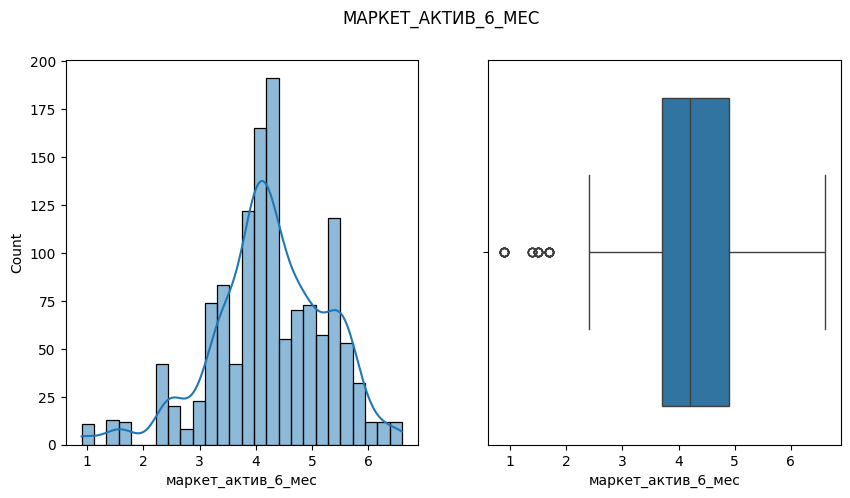

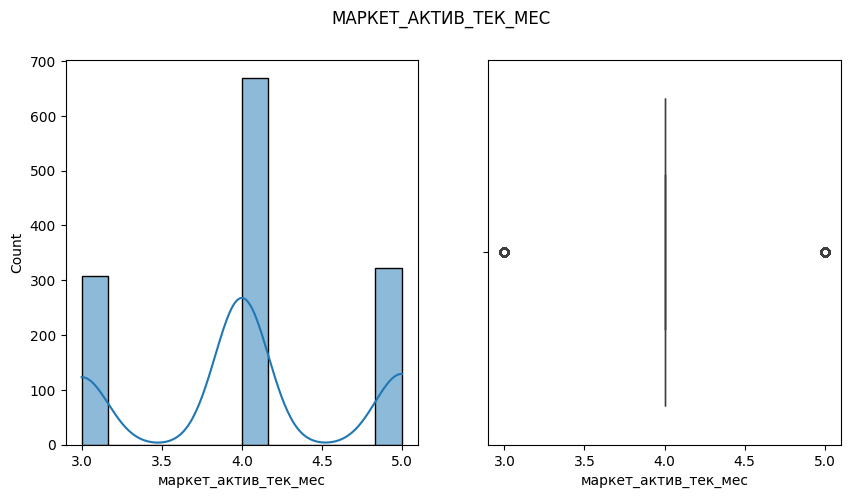

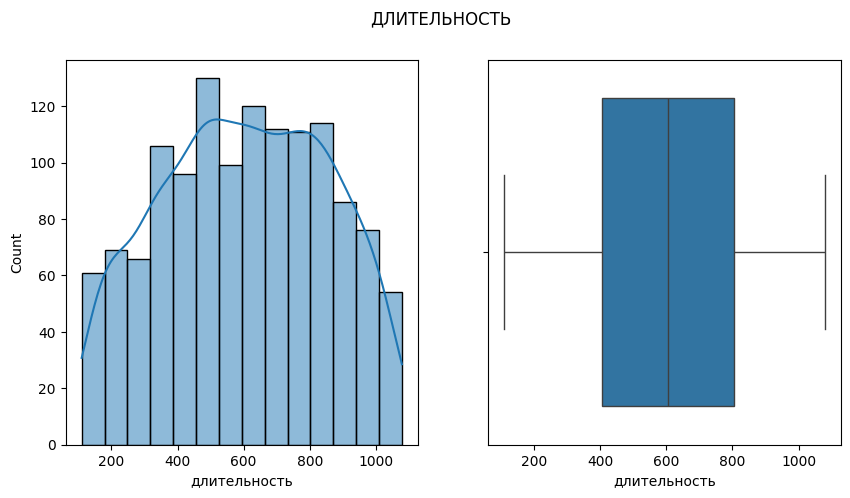

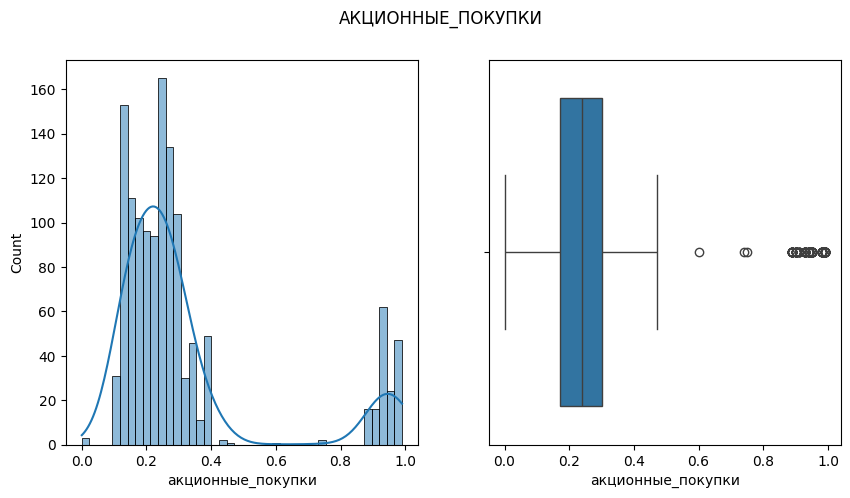

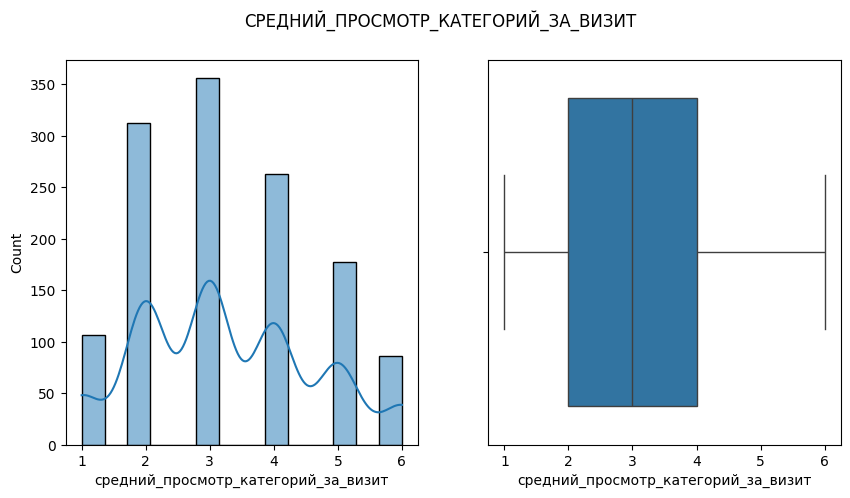

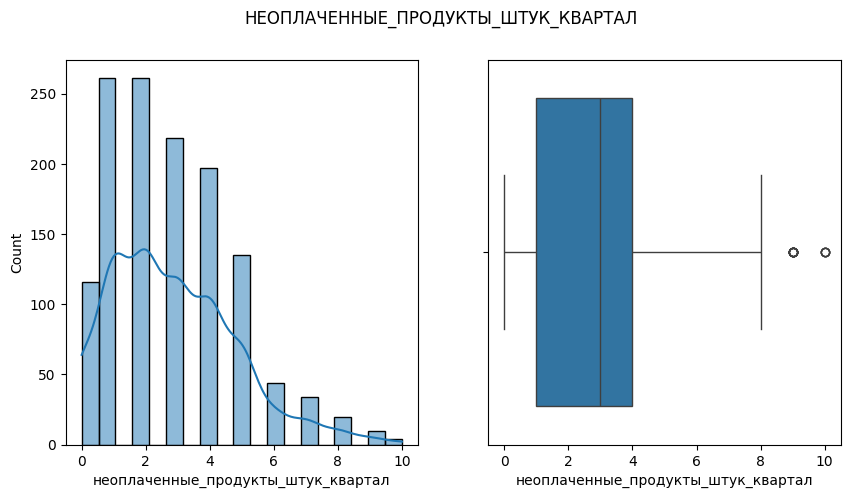

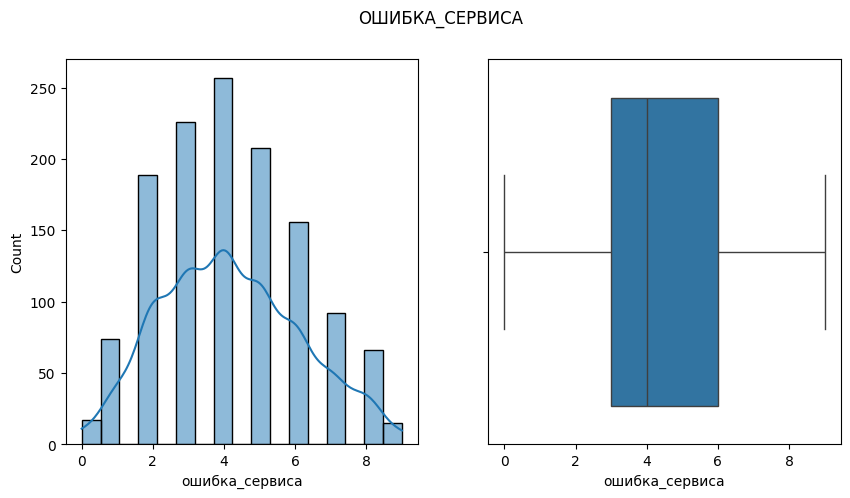

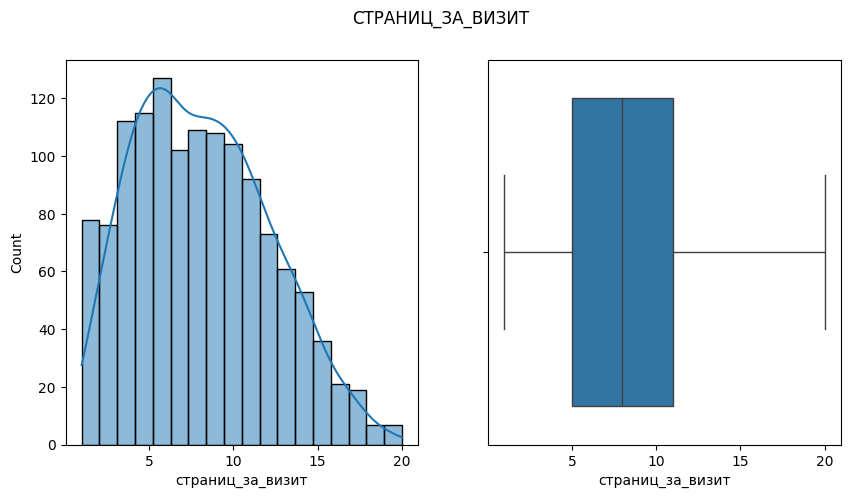

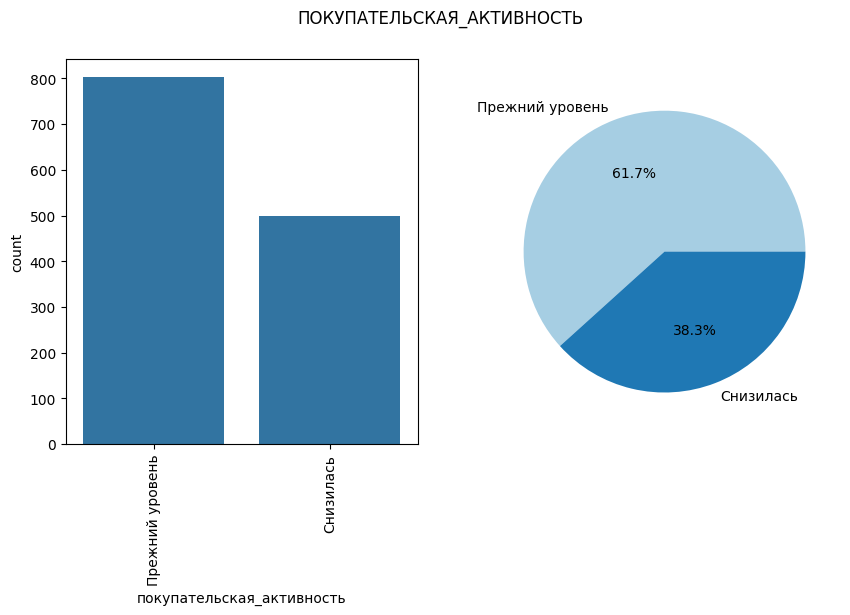

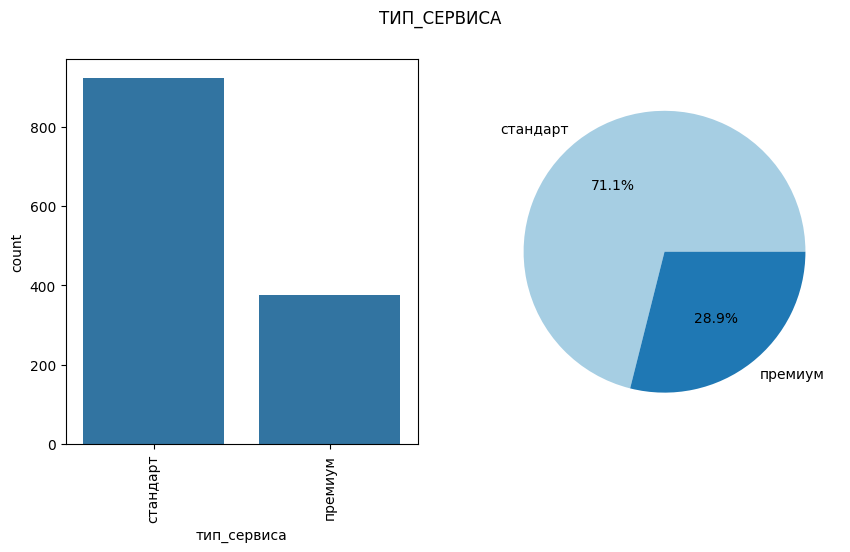

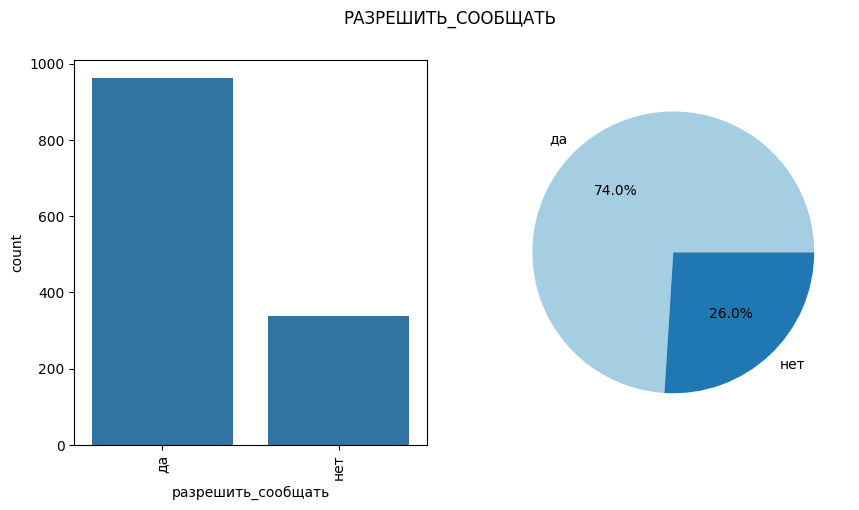

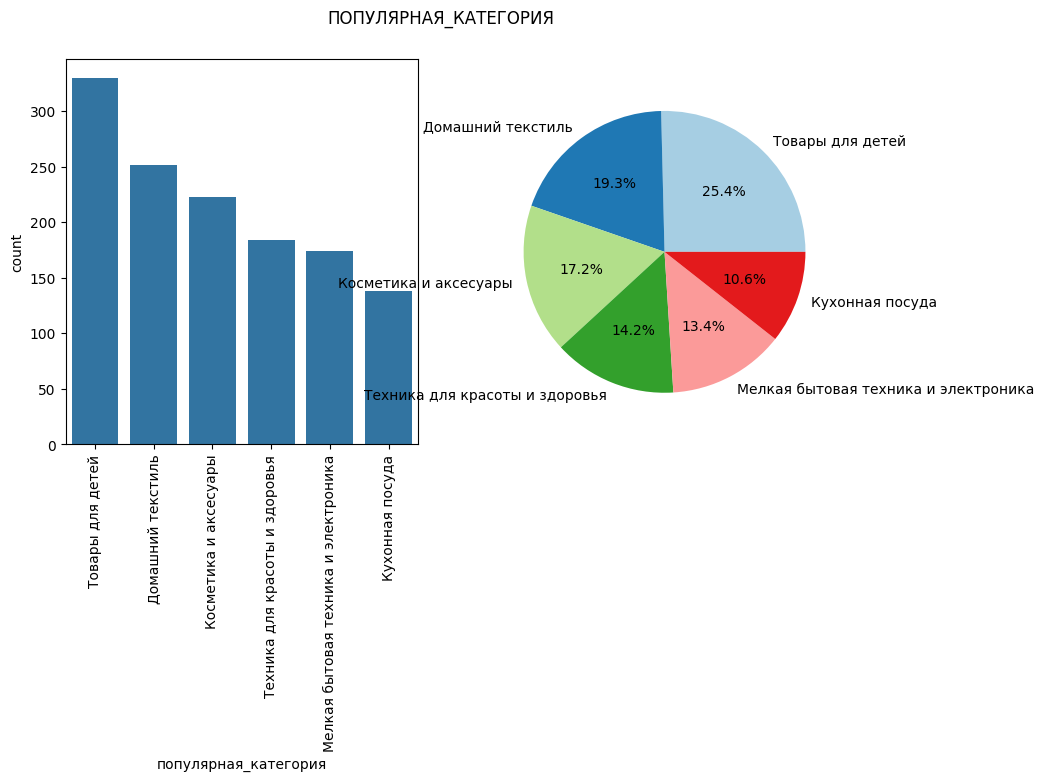

,id,выручка
count,3900.00,3900.00
mean,215997.50,5025.70
std,375.33,1777.70
min,215348.00,0.00
25%,215672.75,4590.15
50%,215997.50,4957.50
75%,216322.25,5363.00
max,216647.00,106862.20


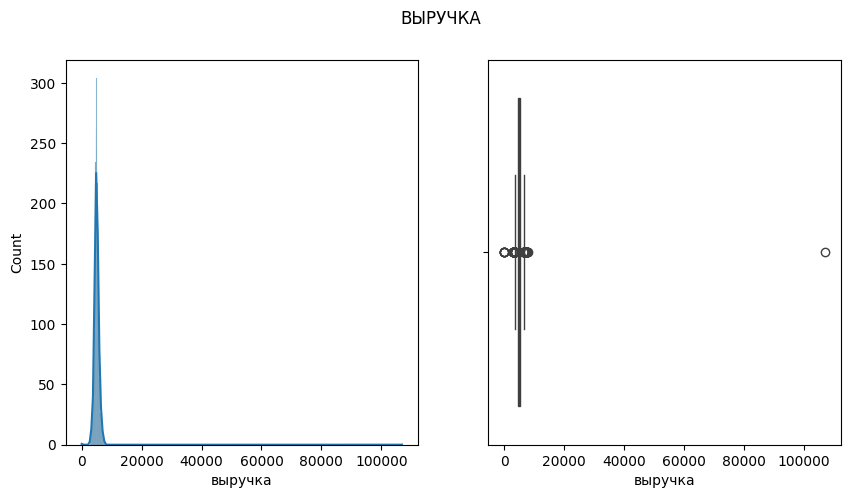

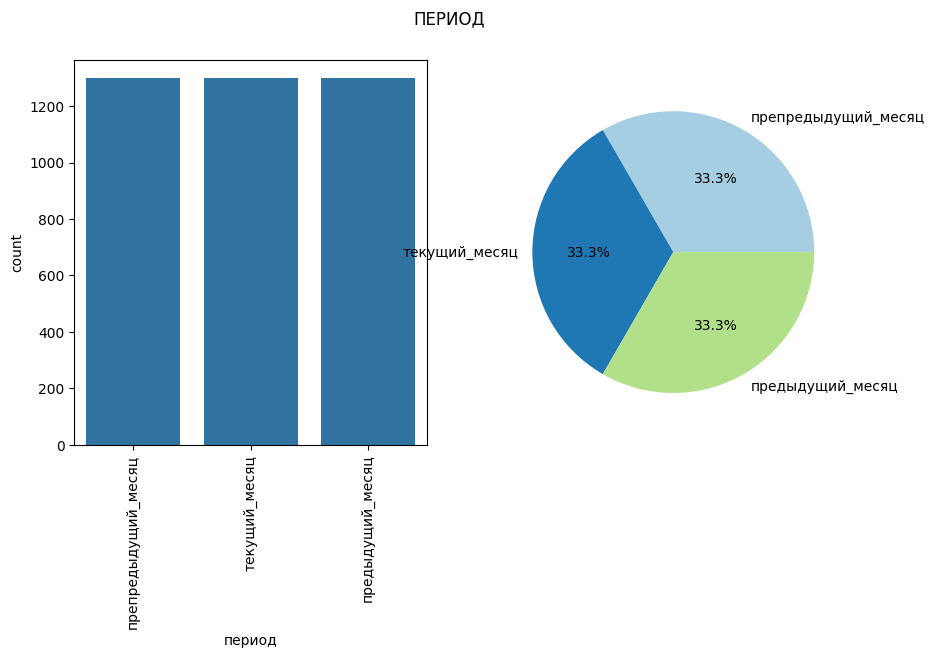

,id,минут
count,2600.00,2600.00
mean,215997.50,13.34
std,375.35,4.08
min,215348.00,4.00
25%,215672.75,10.00
50%,215997.50,13.00
75%,216322.25,16.00
max,216647.00,23.00


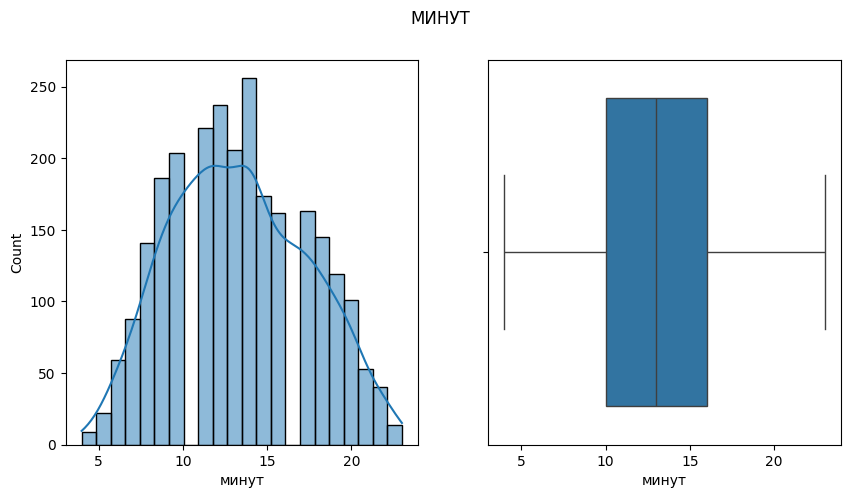

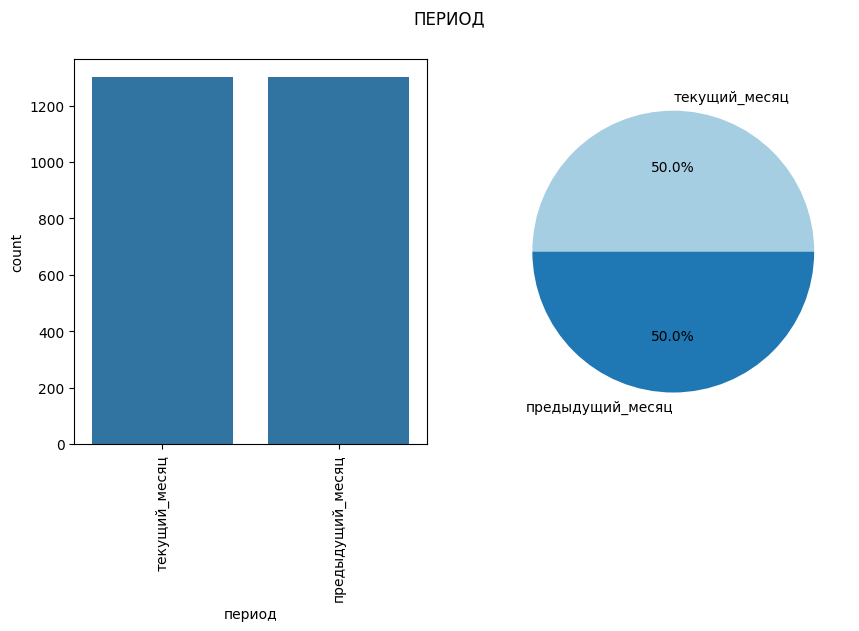

,id,прибыль
count,1300.00,1300.00
mean,215997.50,3996.63
std,375.42,1013.72
min,215348.00,860.00
25%,215672.75,3300.00
50%,215997.50,4045.00
75%,216322.25,4670.00
max,216647.00,7430.00


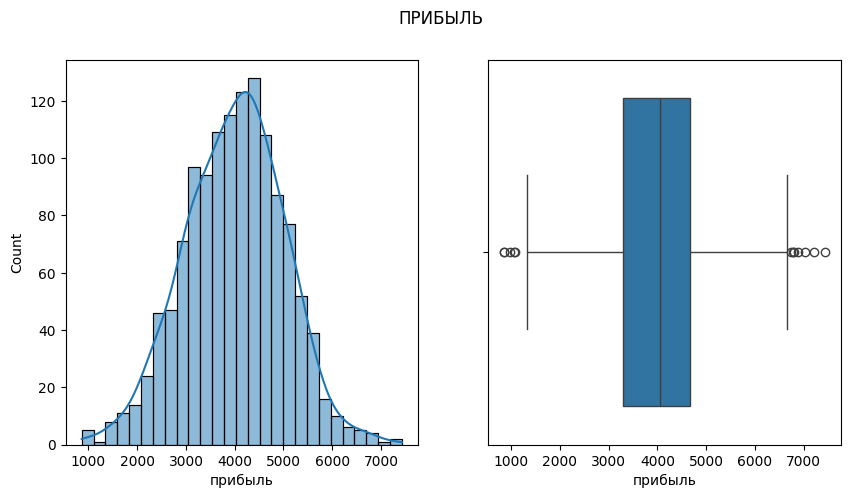

In [19]:
for df in [market_file, market_money, market_time, money]:
    hist_box_pie(df)
# hist_box_pie(market_file)

Предварительные выводы по полученному описанию данных и диаграммам.

market_file:
- среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев - в среднем кленты получали за последние пол года 4 маркетинговых сообщения.
- половина из этих сообщений были отправлены в текущем месяце - большинство клиентов получили за последний месяц 4 маркетинговых сообщения. 
-  основная часть клиентов зарегистрировалась на сайте в период от 400 до 800 дней назад. 25 процентов зарегистрировались на сайте менее года назад.
- за последние 6 месяцев покупки на сайте по акции делаются в 20% от всех покупок. Так же есть группа клиентов, которые делают покупки на сайте исисключительно по акции.
- за один визит 50% клиентов проссматривают товары в пределах 2-4 категорий. чаще всего в 3 категориях товаров.
- чаще всегоо не оплаченными остаются от 2 до 4 товаров в брошеных корзинах
- в среднем на каждого покупателя приходится от 3 до 6 случаев сбоя на сайте
- за визит пользоатель сайта просматривает от 5 до 11 страниц. В среднем 8 страниц.
- покупательская активность промаркирована, как сниженная у 38% покупателей.
- 29% просетителей обслуживают по типу сервиса уровня премиум
- 74% покупателей дали согласие на получение дополнительных сообщений о товаре
- самыми популярными категориями за последние 6 месяцев у покупателей стали товары для детей, домашний текстиль, косметика и аксессуары.



Убираем из фрейма market_money значения выручки больше 80000

In [20]:
market_money = market_money[market_money['выручка']<80000]

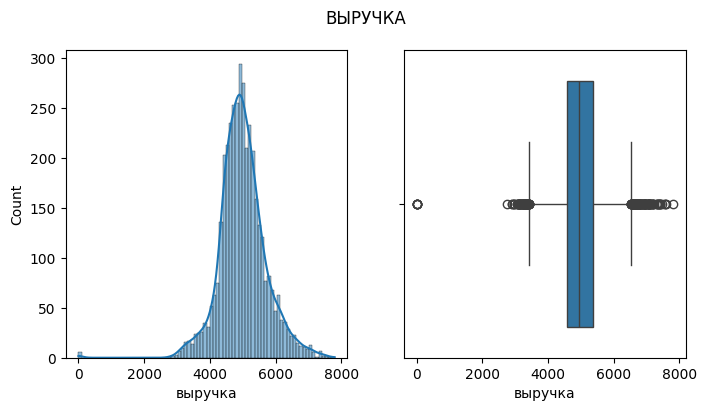

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
f = sns.histplot(x='выручка', data=market_money, bins='auto', kde=True, ax=axes[0])
f = sns.boxplot(x='выручка', data=market_money, ax=axes[1])
f = fig.suptitle(str.upper('выручка'))
plt.show()

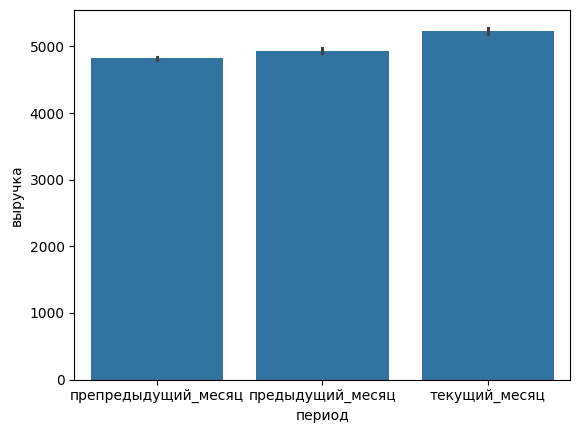

In [22]:
# market_money.pivot_table(index='период')
# mm = market_money.pivot_table(index='период').reset_index().plot(x='период', y='выручка');

# 'препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц', 
# market_money
# sns.pairplot(market_money[['выручка', 'период']].sample(frac=0.2, random_state=RANDOM_STATE), hue='период')
# plt.show()
# sns.countplot(x='выручка', data=market_money, 
#                     order=market_money['период'].value_counts(ascending=False).index,
#                     ax=ax
#              );


# sns.countplot(x='выручка', data=mm, 
#                     order=market_money['период'].value_counts(ascending=False).index,
#                     ax=ax
#              );

# plt.show()
# sns.lineplot(data=mm, x="период", y="выручка");
sns.barplot(data=market_money, x="период", y="выручка", order=market_money['период'].value_counts(ascending=False).index,);

Средняя выручка с покупателя за последние 3 месяца выросла с 4,9 тыс. р. до 5,3 тыс. р. 

In [23]:
market_time.pivot_table(index='период')

,id,минут
период,,
предыдущий_месяц,215997.50,13.47
текущий_месяц,215997.50,13.20


В среднем на сайте проводят время от 10 до 16 минут. Но в последний месяц в среднем посетители стали проводить на сайте на 30 секунд меньше по сравнению с предыдущим месяцем.

С каждого клиента в среднем магазин получает 4000 р прибыли.

И отберем покупателей с id у которых суммарная прибыль за последние 3 месяца в каждом месяце была не нулевой.
Сначала market_money

Ищем период с отсутствием выручки и id таких клиентов.

In [24]:
temp_df = market_money[market_money['выручка']==0]
id_to_del = temp_df.id.unique().tolist()
print('id на удаление:', id_to_del)

id на удаление: [215348, 215357, 215359]


Корректируем фрейм.

In [25]:
market_money = market_money.query('id not in @id_to_del')
market_money.shape

(3890, 3)

Выручка за 3 месяца есть по всем клеинтам в датафрейме market_money. Теперь проверяем money:

In [26]:
temp_df = money.pivot_table(index='id', values='прибыль', aggfunc='sum').reset_index()
temp_df[temp_df['прибыль']==0].count()

id         0
прибыль    0
dtype: int64

id клиентов с нулевой прибылью за 3 месяца нет. Следовательно берем все данные из таблиц. 

Теперь объединим все таблицы в один фрейм по id.


Преобразовываем данные таблицы market_money. Разворачиваем "вширь" по id методом pivot_table.

In [27]:
market_money_pivot = market_money.pivot_table(index='id', columns='период', values='выручка', aggfunc='sum').reset_index()
market_money_pivot
market_money_pivot.rename(columns = {'препредыдущий_месяц':'выручка_препредыдущий_месяц', 'предыдущий_месяц':'выручка_предыдущий_месяц', 'текущий_месяц':'выручка_текущий_месяц'}, inplace = True )
market_money_pivot.head()

период,id,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
0,215349,5216.00,4472.00,4971.60
1,215350,5457.50,4826.00,5058.40
2,215351,6158.00,4793.00,6610.40
3,215352,5807.50,4594.00,5872.50
4,215353,4738.50,5124.00,5388.50


Преобразовываем данные таблицы market_time

In [28]:
market_time_pivot = market_time.pivot_table(index='id', columns='период', values='минут', aggfunc='sum').reset_index()
market_time_pivot
market_time_pivot.rename(columns = {'предыдущий_месяц':'минуты_предыдущий_месяц', 'текущий_месяц':'минуты_текущий_месяц'}, inplace = True )
market_time_pivot.head()

период,id,минуты_предыдущий_месяц,минуты_текущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


Объединяем 3 таблицы

Перед объединением выкидываем из основной таблицы клиентов с нулевой выручкой.

In [29]:
market_file = market_file.query('id not in @id_to_del')
market_file.shape

(1297, 13)

In [30]:
df = market_file.merge(market_money_pivot, on='id', how='left')
df = df.merge(market_time_pivot, on='id', how='left')
df.shape

(1297, 18)

Проверияем на отсутствие клиентов с нулевой выручкой в объединенном фрейме.

In [31]:
df = df[df['выручка_текущий_месяц']!=0]
df[df['выручка_текущий_месяц'] == 0]

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдущий_месяц,минуты_текущий_месяц


Проверяем что получилось.

In [32]:
df.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдущий_месяц,минуты_текущий_месяц
0,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5,5216.00,4472.00,4971.60,12,10
1,215350,Снизилась,стандарт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5,5457.50,4826.00,5058.40,8,13
2,215351,Снизилась,стандарт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4,6158.00,4793.00,6610.40,11,13
3,215352,Снизилась,стандарт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2,5807.50,4594.00,5872.50,8,11
4,215353,Снизилась,стандарт,да,3.30,4,762,0.26,Домашний текстиль,4,1,1,4,4738.50,5124.00,5388.50,10,10


Проверяем на пропуски, удаляем.

In [33]:
df.isna().sum().sum()

1

In [34]:
df.dropna(inplace= True)
df.isna().sum().sum()

0

Таблицы объединены успешно. Можем двигатся дальше.

## Корреляционный анализ
Проверим признаки на мультиколлинеарность. 

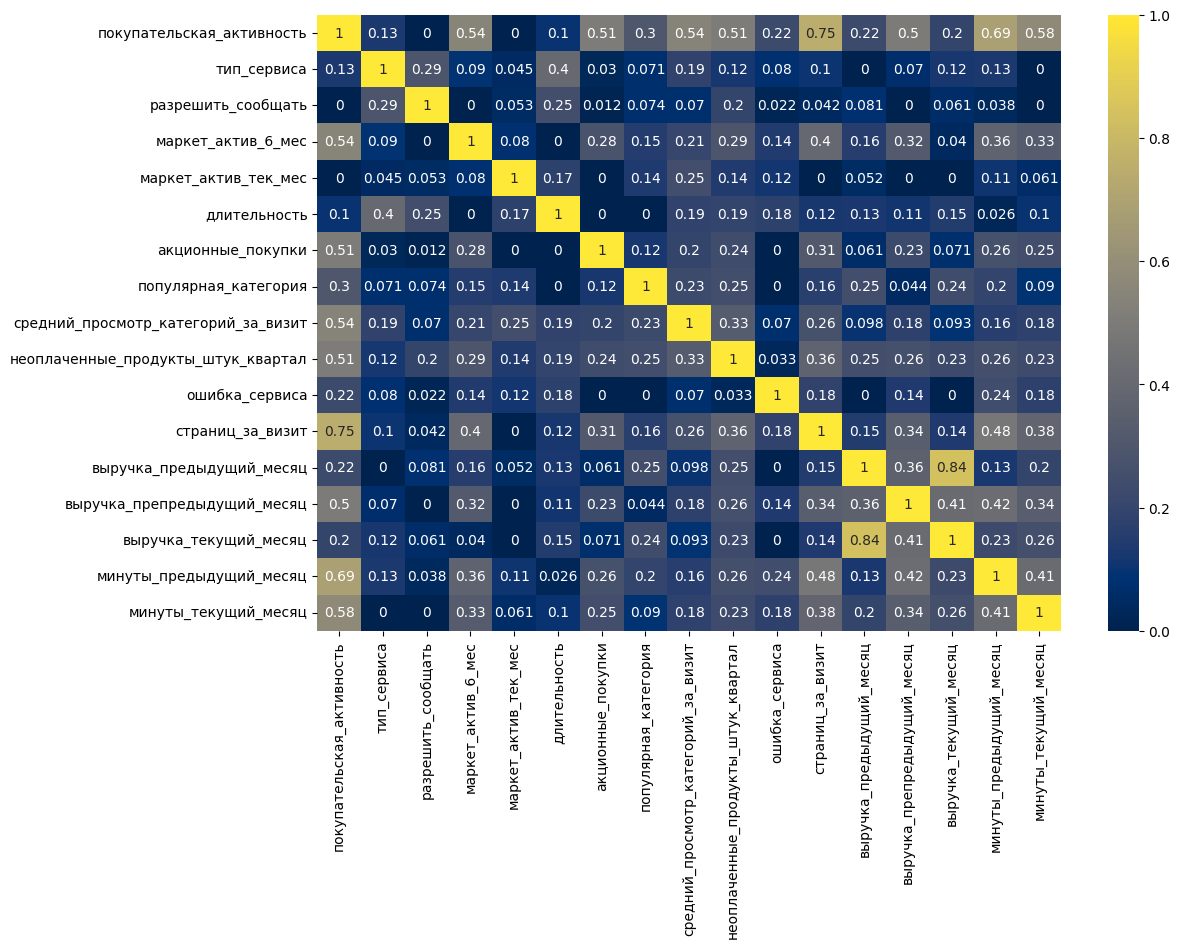

In [35]:
num_cols = df.select_dtypes(include='number').columns.drop('id').tolist()
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df.drop(columns=['id']).phik_matrix(interval_cols=num_cols,) , annot=True, cmap='cividis');
plt.show()

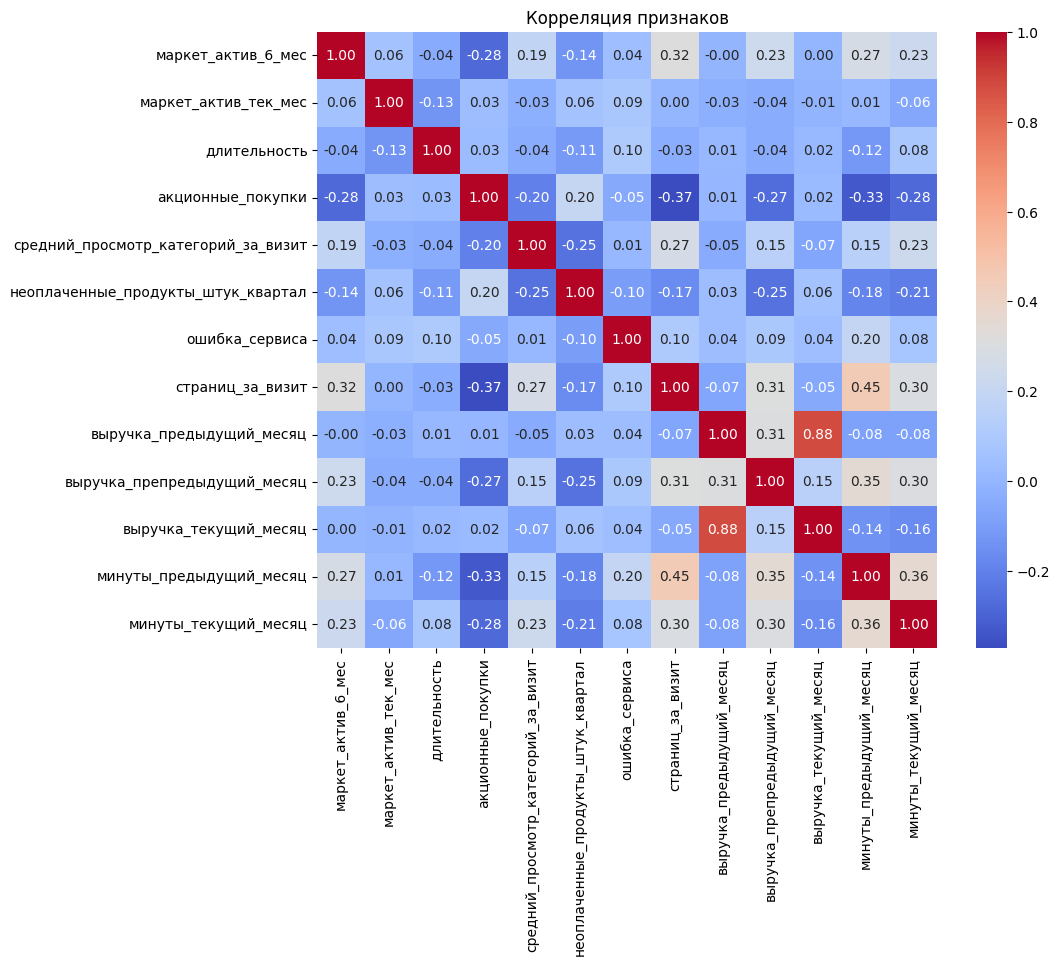

In [36]:
num_cols = df.select_dtypes(include='number').columns.drop('id').tolist()
plt.figure(figsize=(10,8))
# fig = sns.heatmap(ferma_main[[*num_cols]].corr(), annot=True, fmt='.2f', cmap='coolwarm')
fig = sns.heatmap(df[[*num_cols]].corr(method='spearman'), annot=True, fmt='.2f', cmap='coolwarm')
fig.set_title('Корреляция признаков')
plt.show()

Ярко выраженной корреляции в данных нет. Можно переходить к следующему этапу.

## Пайплайн
Для подготовки и поиска наилучшей модели классификации будем использовать пайплайн для всех моедлей и инструмент для подбора гиперпараметров к ним в едином пайплайне. Обучим 4 модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(). Выделим в разные списки признаки разных типов для работы с каждым в своем пайплайне. 

In [37]:
ohe_columns = ['популярная_категория']
ord_columns = ['тип_сервиса', 'разрешить_сообщать']
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
               'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
               'страниц_за_визит', 'выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 
               'выручка_текущий_месяц',	'минуты_предыдущий_месяц', 'минуты_текущий_месяц'] 

In [38]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
) 

In [39]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [40]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
) 

param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1,6),
        'models__max_features': range(1,6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passtgrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passtgrough']
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__degree': range(1,6),
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'models__C': [0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passtgrough']
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__solver': ['liblinear'],
        'models__penalty': ['l1', 'l2'],
        'models__C': range(1,6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passtgrough']
    },    
]

Делим данные с применением стратификации.

In [41]:
X = df.drop(['id', 'покупательская_активность'], axis=1)
y = df['покупательская_активность']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y
)

Преобразовываем целевой признак

In [42]:
label_encoder = LabelEncoder() 
y_train = label_encoder.fit_transform(y_train) 
y_test = label_encoder.transform(y_test)
print(label_encoder.classes_)
print(label_encoder.inverse_transform([0, 1])) 
# 1 - активность снизилась

['Прежний уровень' 'Снизилась']
['Прежний уровень' 'Снизилась']


Выбираем метрику для подбора моделей ROC-AUC, как наиболее универсальную и отвечающую за общий для любой модели показатель качества модели - площадь под кривой функции. Чем больше - тем лучше. Победит та модель, которая окажется лучше. 

In [43]:
# grid = RandomizedSearchCV(
#     pipe_final,
#     param_grid,
#     cv=5,
#     random_state=RANDOM_STATE,
#     scoring='roc_auc',
#     n_jobs=-1,
#     n_iter=50
# )

grid = GridSearchCV(
    pipe_final,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid.fit(X_train, y_train)

print('Лучшая модель и параметры:', grid.best_estimator_['models'])

print('Ядро модели и праметры:', grid.best_estimator_['models'].kernel)
print('метрика лучшей модели:', grid.best_score_)

Лучшая модель и параметры: SVC(C=0.1, degree=1, probability=True, random_state=42)
Ядро модели и праметры: rbf
метрика лучшей модели: 0.9110794902340356


Лучшая модель и ее параметры: 'models', SVC(C=0.1, degree=1, probability=True, random_state=42), ядро 'rbf'. Ее и выбираем для дальнейшего исследования важности признаков.

In [44]:
y_train_proba = grid.predict_proba(X_train)[:,1]
y_pred_proba = grid.predict_proba(X_test)[:,1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, y_pred_proba))

Площадь ROC-кривой: 0.9112567245075436


На тренировочной выборке значение 0.91 на тесте 0.91. Модель доказала адекватность предсказаний.

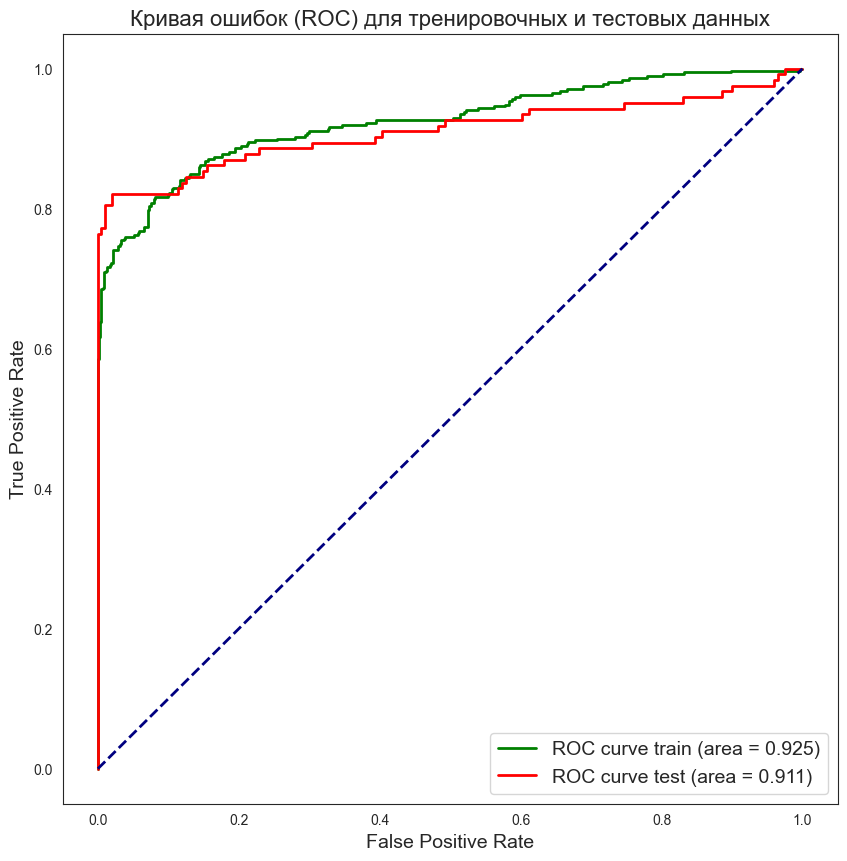

In [45]:
fpr1, tpr1, _ = roc_curve(y_train, y_train_proba)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test, y_pred_proba)
roc_auc2 = auc(fpr2, tpr2)

sns.set_style('white')
plt.figure(figsize=(10, 10))
plt.plot(fpr1, tpr1, color='green', lw=2, label='ROC curve train (area = %0.3f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='red', lw=2, label='ROC curve test (area = %0.3f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Кривая ошибок (ROC) для тренировочных и тестовых данных', size=16)
plt.legend(loc="lower right", fontsize=14)
plt.show()

## Анализ важности признаков
Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP. 

In [46]:
shap.plots.initjs()

In [47]:
x_Train = pd.DataFrame(
    pipe_final.named_steps['preprocessor'].fit_transform(X_train),
    columns=pipe_final.named_steps['preprocessor'].get_feature_names_out()
)
x_Test = pd.DataFrame(
    pipe_final.named_steps['preprocessor'].transform(X_test),
    columns=pipe_final.named_steps['preprocessor'].get_feature_names_out()
)

# model = DecisionTreeClassifier(max_depth=4, max_features=5, random_state=RANDOM_STATE)
model = SVC(C=0.1, degree=1, probability=True, random_state=42)
model.fit(x_Train, y_train)

# explainer = shap.KernelExplainer(model.predict_proba, x_Train[:10])
# shap_values = explainer.shap_values(x_Test[:10])[:, :, 1] # берем вероятности для целевого признака = 1 (снижение активности)
# shap.force_plot(explainer.expected_value[1], shap_values, x_Test)

SVC(C=0.1, degree=1, probability=True, random_state=42)

In [48]:
explainer = shap.KernelExplainer(model.predict_proba, x_Train[:15])
shap_values = explainer.shap_values(x_Test[:15])[:, :, 1] # берем вероятности для целевого признака = 1 (снижение активности)
shap.force_plot(explainer.expected_value[1], shap_values, x_Test)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:11<00:00,  4.75s/it]


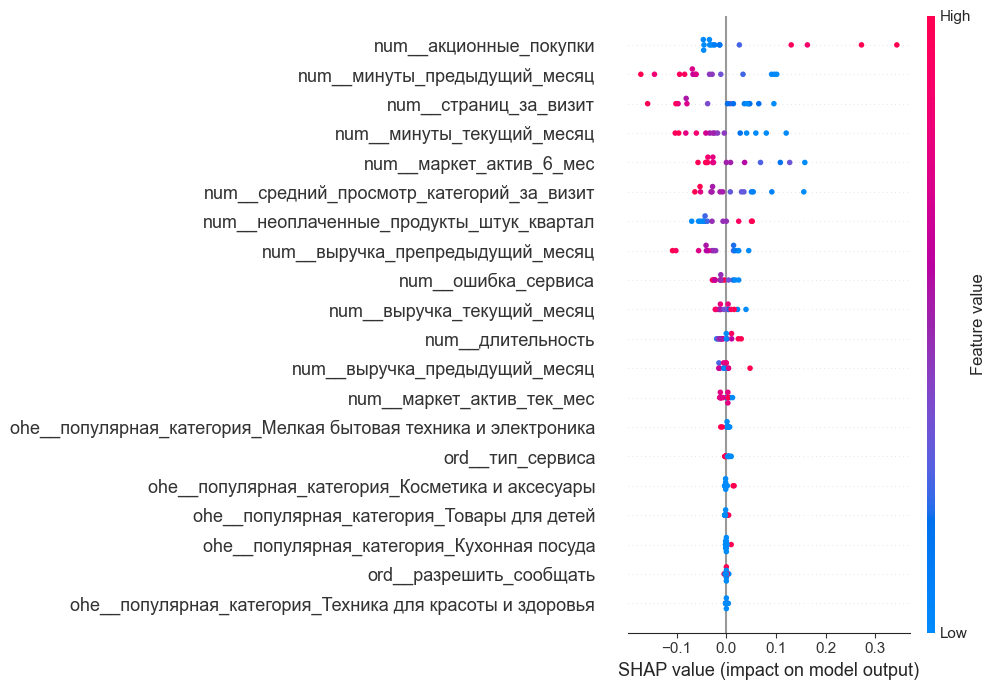

In [49]:
shap.summary_plot(shap_values, x_Test[:15], color_bar=True, max_display=25, plot_size=(10,7))

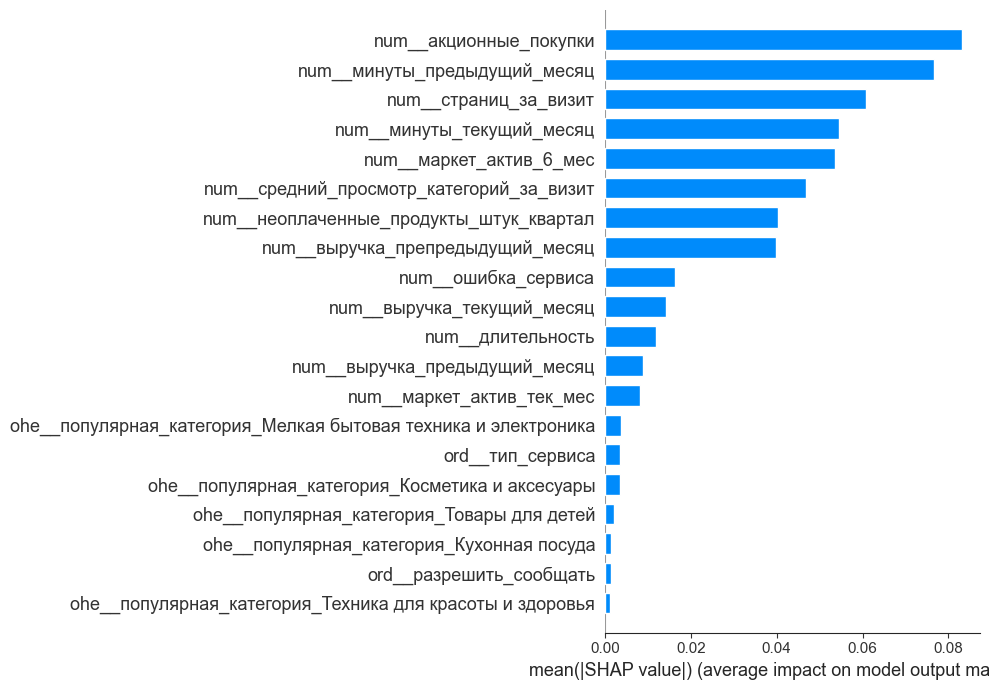

In [50]:
shap.summary_plot(shap_values, x_Test, plot_type='bar', plot_size=(10,7))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:02<00:00,  3.14s/it]


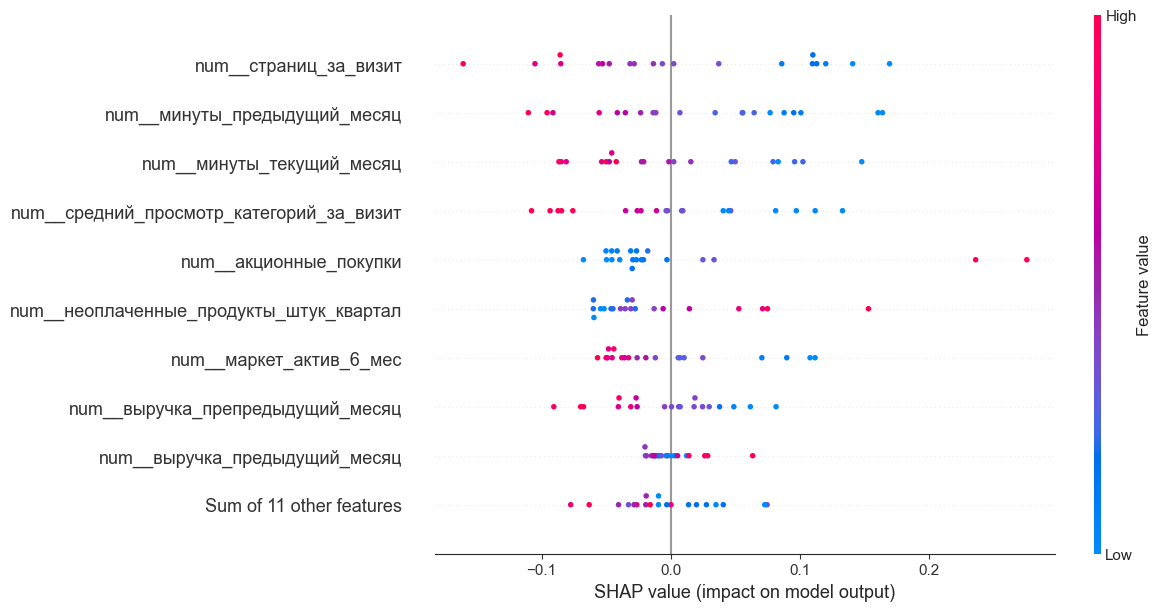

In [51]:
explainer = shap.KernelExplainer(model.predict_proba, x_Train[:10])
shap_values = explainer(x_Train[:20])
shap.plots.beeswarm(shap_values[:,:,1], max_display=10, show=True, color_bar=True, plot_size=(10,7))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:31<00:00,  3.15s/it]


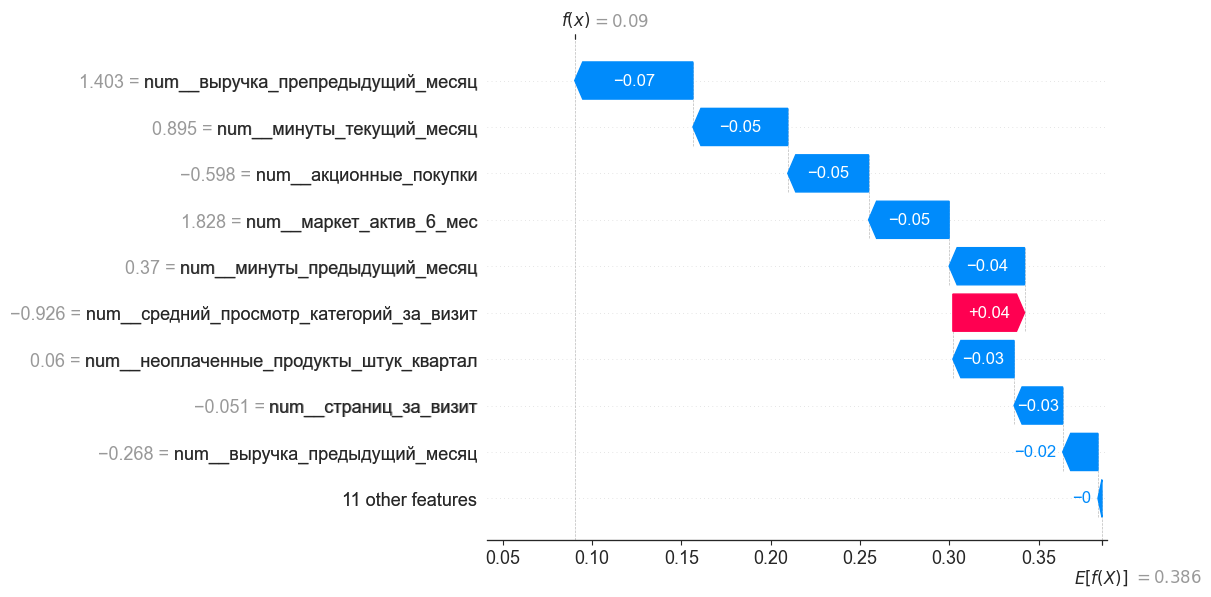

In [52]:
explainer = shap.KernelExplainer(model.predict_proba, x_Train[:10])
shap_values = explainer(x_Train[:10])
exp = shap.Explanation(shap_values[:,:,1], shap_values.base_values[:,1], x_Train[:10])
idx = 7 # datapoint to explain
shap.waterfall_plot(shap_values[idx,:,1])

Сделаем выводы:

Важные признаки:

- страниц за визит - чем меньше страниц тем больше вероятность снижения активности
- минуты за предыдущий месяц, минты за текущий  - чем больше, тем меньше вероятность снижения активности
- доля акционных покупок - чем их меньше, тем меньше вероятность снижения активности
- минуты текущего сеанса - чем дольше на сайте, тем меньше вероятность снижения активности
- средний просмотр категорий за визит - чем их больше, тем меньше вероятность снижения активности
- неоплаченные продукты в квартал - чем их больше, тем больше вроятность снижения активности 
- маркетинговая активность за 6 месяцев - чем больше, тем меньше вероятность снижения актвности.

Выводы для выработки бизнес-решений могут быть такие: 
Стимулировать клиента проводить на сайте дольше времени, открывать больше страниц, посещать больше категорий товаров, воздействовать через маркетинговые сообщения.

## Сегментация покупателей
Используя результаты моделирования и данные о прибыльности покупателей проведем сегментацию. 

К полученной модели добавим данные о вероятности появления целевого признака равного 1 (снижение активности). Применим модель ко всей выборке покупателей и выведем предсказания и вероятности, добавим данные о прибыли и построим график - по X будут вероятности, по Y - прибыль. Цветом выведем показатель снижения активности.

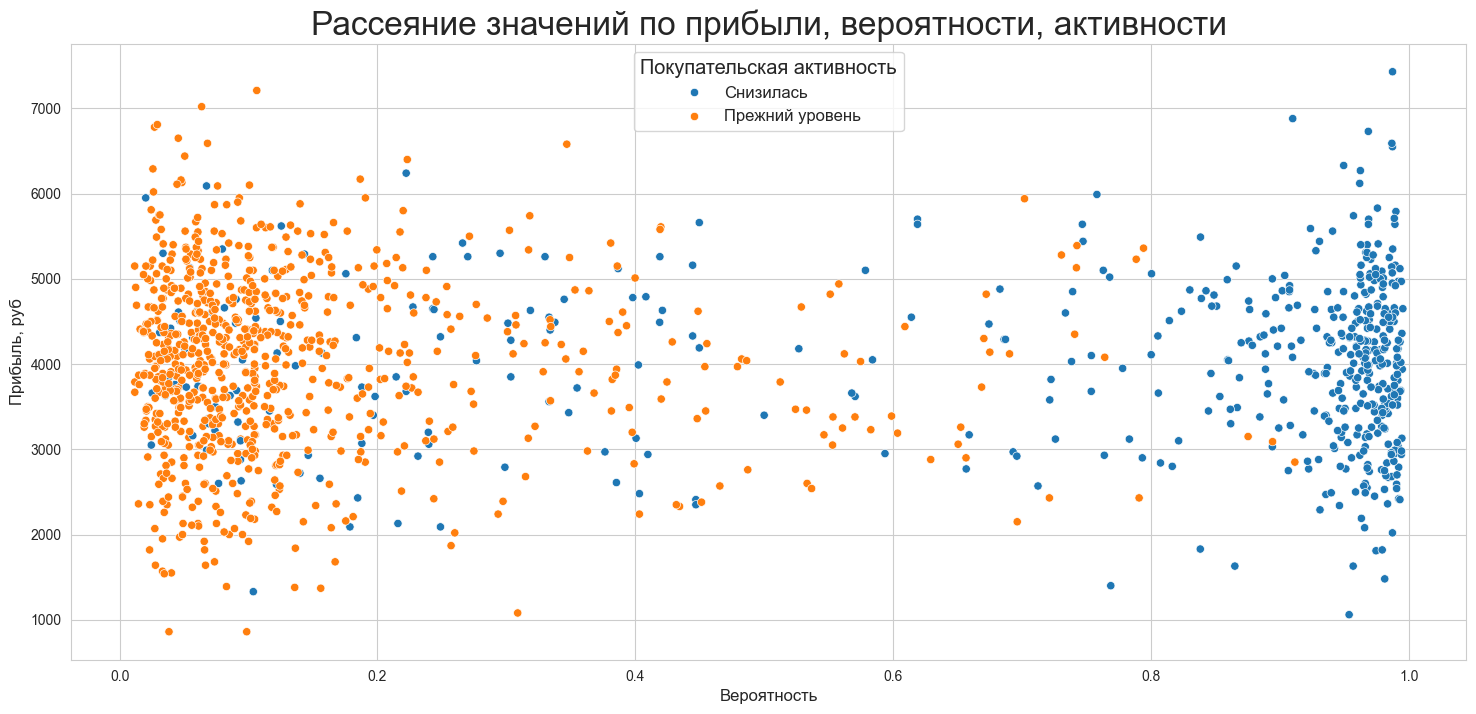

In [53]:
all_df = df.copy()
X = df.drop(['id', 'покупательская_активность'], axis=1)

X_transform = pd.DataFrame(
    pipe_final.named_steps['preprocessor'].fit_transform(X),
    columns=pipe_final.named_steps['preprocessor'].get_feature_names_out()
)
y_proba = model.predict_proba(X_transform)[:,1]
y_proba = pd.Series(y_proba).to_frame(name='вероятность')
all_df = pd.concat([all_df, y_proba], axis=1)

# all_df
fin_frame = all_df.merge(money, on='id', how='left')
fin_frame.head()

# Рисуем
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(18, 8))
sns.scatterplot(data=fin_frame, x='вероятность', y='прибыль', hue='покупательская_активность');
plt.xlabel('Вероятность', size = 12 ) 
plt.ylabel('Прибыль, руб', size = 12 ) 
plt.title('Рассеяние значений по прибыли, вероятности, активности', size=24)
plt.legend(fontsize='large', title_fontsize='x-large', title='Покупательская активность', loc='upper center')
plt.show()

Делаем выводы. 

Видно довольно четкое разделение по вероятности и цвету - модель довольно хорошо уловила разницу. Работать будем прежде всего с клиентами со снизившейся активностью. Так же наиболее логичным будет в первую очередь заняться исследованием клиентов с максимальными значениями прибыли. На графике это условно клиенты в правой верхней четверти - высокодоходные и с высокой вероятностью снижения активности. Выделим сегмент в отдельный фрейм и проведем анализ признаков. В качестве границ берем вероятность снижения активности больше 0.6 и прибылью больше 4000 руб.

In [54]:
tagret_frame = fin_frame[(fin_frame['прибыль'] > 4000) & (fin_frame['вероятность'] > 0.6) & (fin_frame['вероятность'] < 1.0)]

In [55]:
tagret_frame.shape

(211, 20)

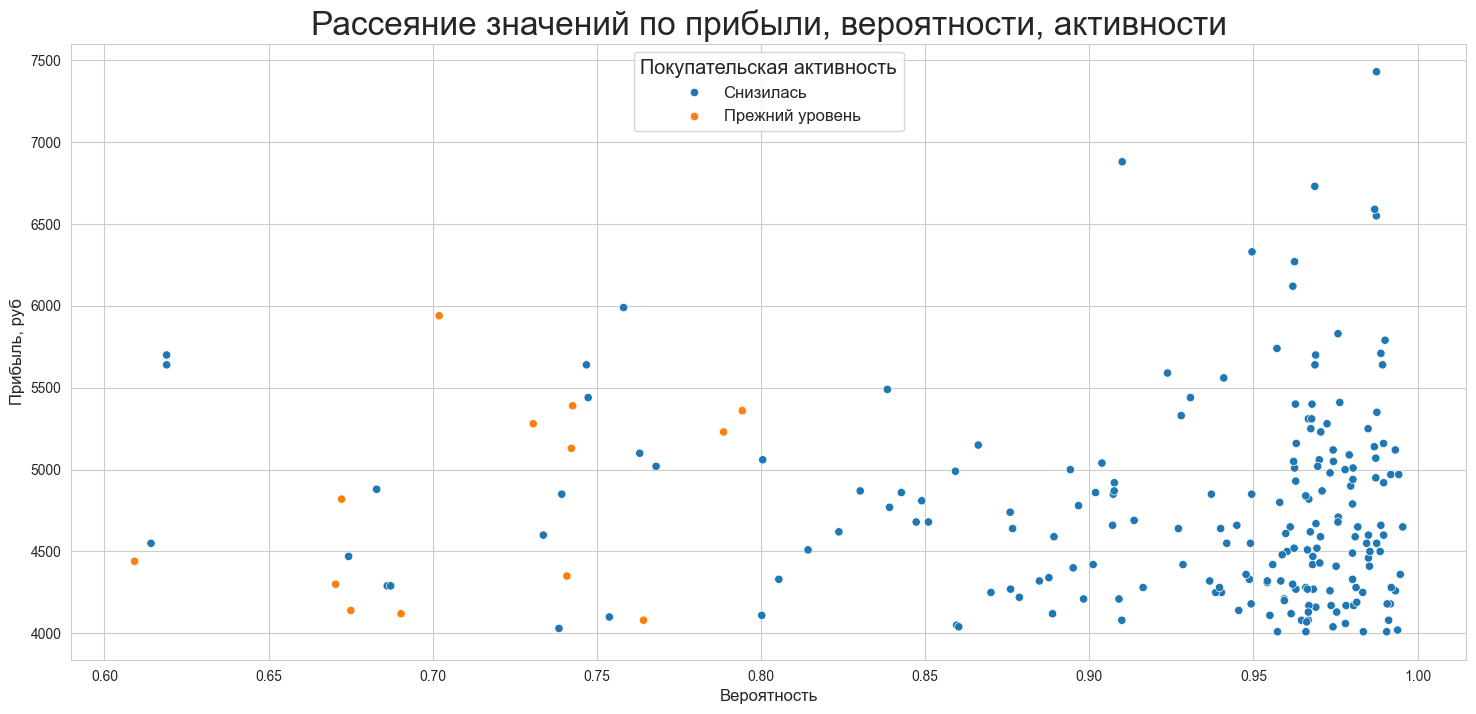

In [56]:
# Рисуем этот сегмент
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(18, 8))
sns.scatterplot(data=tagret_frame, x='вероятность', y='прибыль', hue='покупательская_активность');
plt.xlabel('Вероятность', size = 12 ) 
plt.ylabel('Прибыль, руб', size = 12 ) 
plt.title('Рассеяние значений по прибыли, вероятности, активности', size=24)
plt.legend(fontsize='large', title_fontsize='x-large', title='Покупательская активность', loc='upper center')
plt.show()

In [57]:
tagret_frame.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минуты_предыдущий_месяц,минуты_текущий_месяц,вероятность,прибыль
0,215349.00,Снизилась,премиум,да,4.40,4.00,819.00,0.75,Товары для детей,4.00,4.00,2.00,5.00,5216.00,4472.00,4971.60,12.00,10.00,0.97,4160.00
2,215351.00,Снизилась,стандарт,да,3.20,5.00,896.00,0.99,Товары для детей,5.00,0.00,6.00,4.00,6158.00,4793.00,6610.40,11.00,13.00,0.83,4870.00
3,215352.00,Снизилась,стандарт,нет,5.10,3.00,1064.00,0.94,Товары для детей,3.00,2.00,3.00,2.00,5807.50,4594.00,5872.50,8.00,11.00,0.96,4210.00
7,215356.00,Снизилась,стандарт,да,4.20,4.00,192.00,0.14,Косметика и аксесуары,2.00,2.00,1.00,3.00,4146.50,4433.00,4566.40,6.00,7.00,0.96,4930.00
9,215360.00,Снизилась,премиум,да,3.90,3.00,623.00,0.35,Кухонная посуда,3.00,1.00,4.00,7.00,5304.50,5555.00,5834.90,9.00,6.00,0.61,4550.00


Теперь посмотрим на графиках взаимосвязь между характеристиками клиентов и самыми важными факторами, выявленными в результате shap анализа ранее: страниц за визит, время на сайте в текущем и предыдущем месяце, количество неоплаченных покупок, просмотр категорий за визит, время на сайте в текущем месяце.

In [58]:
df_pivot = tagret_frame.pivot_table(index=['покупательская_активность', 
#                                            'тип_сервиса', 
                                          ], 
                  values=['id', 'прибыль', 'акционные_покупки', 'минуты_текущий_месяц', 'длительность', 
                          'маркет_актив_6_мес', 'средний_просмотр_категорий_за_визит', 'страниц_за_визит'], 
#                   columns=['разрешить_сообщать', ],
                  aggfunc={'акционные_покупки':'mean', 'прибыль': 'mean', 'id': 'count', 
                           'минуты_текущий_месяц': 'mean', 'средний_просмотр_категорий_за_визит': 'mean',
                           'маркет_актив_6_мес': 'mean',
                           'длительность': 'mean',
                          'страниц_за_визит': 'mean'}
                 )
df_pivot

,id,акционные_покупки,длительность,маркет_актив_6_мес,минуты_текущий_месяц,прибыль,средний_просмотр_категорий_за_визит,страниц_за_визит
покупательская_активность,,,,,,,,
Прежний уровень,13,0.25,668.77,4.96,13.62,4813.85,3.31,10.69
Снизилась,198,0.48,629.38,3.52,10.19,4747.37,2.44,4.23


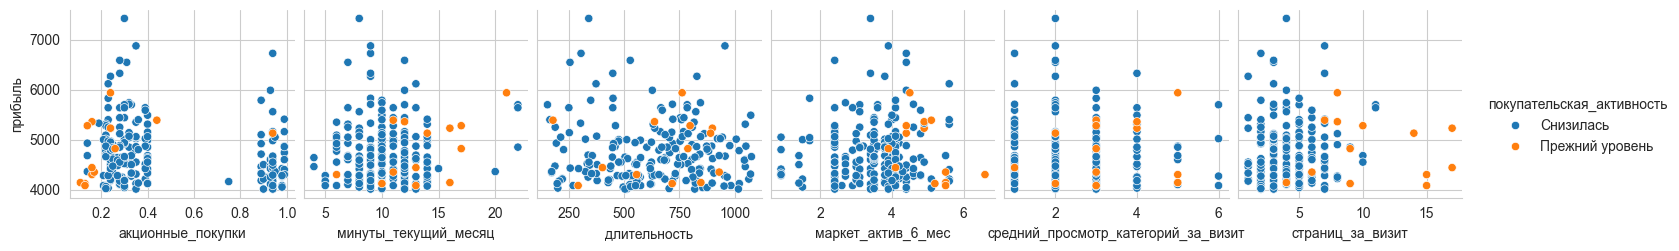

In [59]:
sns.pairplot(data=tagret_frame,    
    x_vars=['акционные_покупки', 'минуты_текущий_месяц', 'длительность', 
            'маркет_актив_6_мес', 'средний_просмотр_категорий_за_визит', 'страниц_за_визит'],
    y_vars=['прибыль', ],
    hue='покупательская_активность'
            );

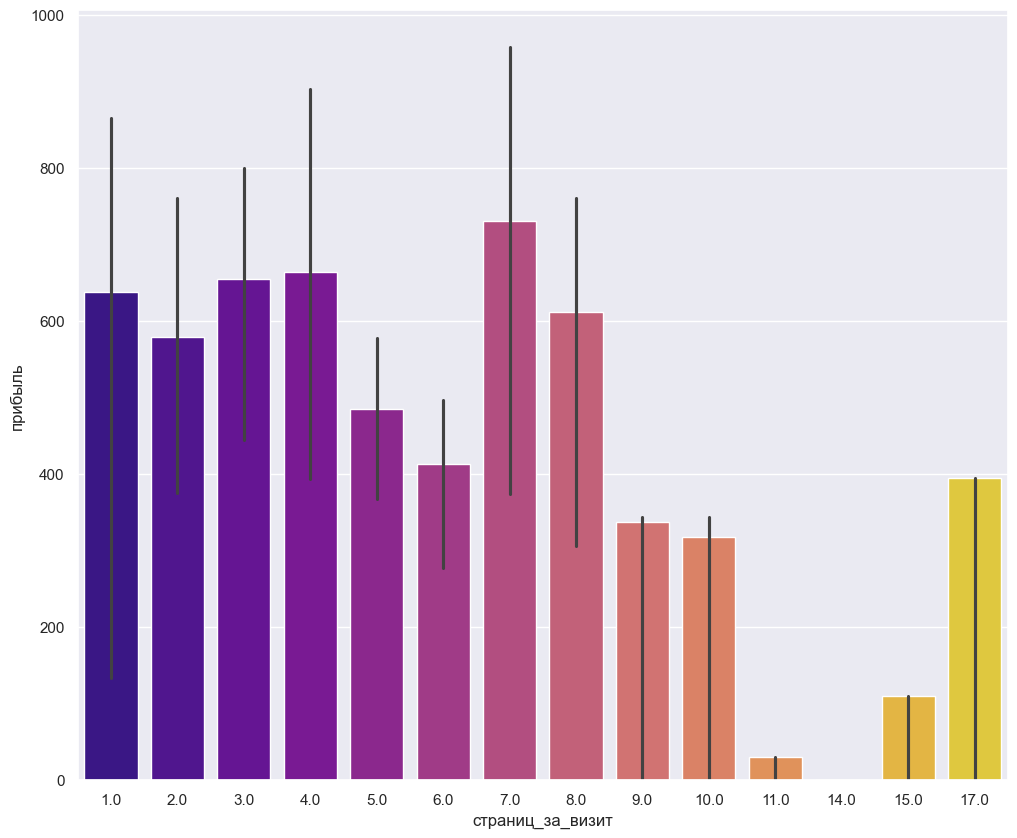

In [60]:
sns.set(rc={'figure.figsize':(12, 10)})
sns.barplot(x ='страниц_за_визит', y ='прибыль', data = tagret_frame, 
            palette ='plasma', 
#             hue ='разрешить_сообщать',
            estimator = np.std);

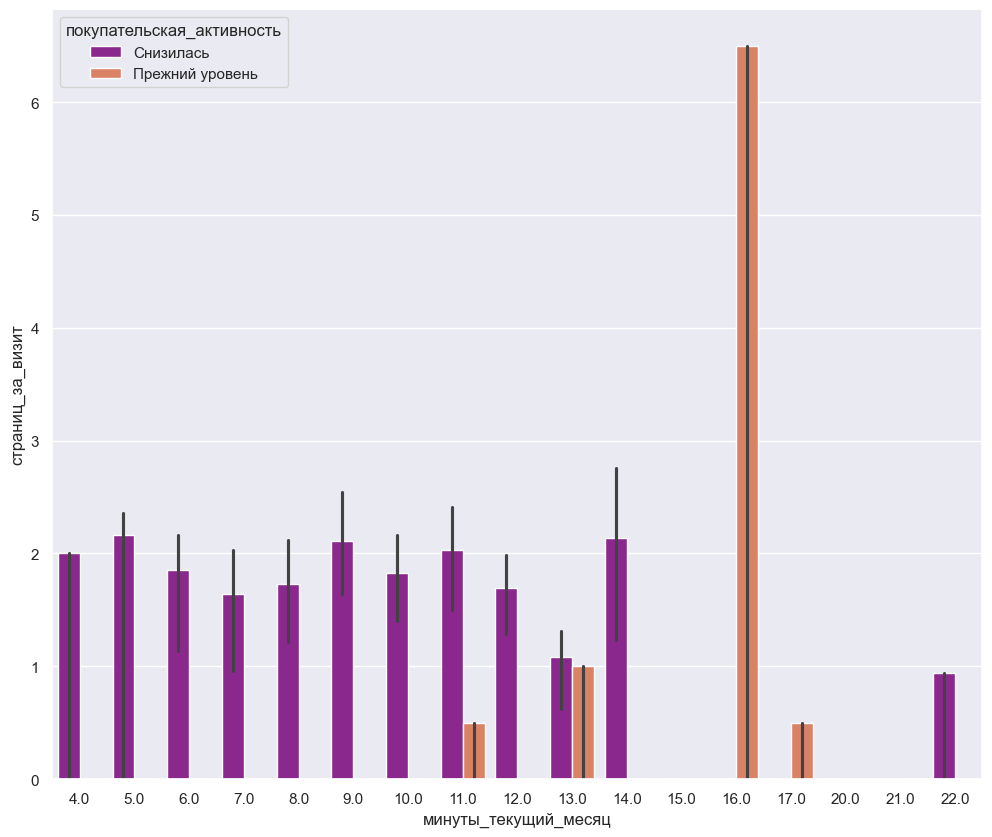

In [61]:
sns.barplot(x ='минуты_текущий_месяц', y ='страниц_за_визит', data = tagret_frame, 
            palette ='plasma', 
            hue ='покупательская_активность',
            estimator = np.std);

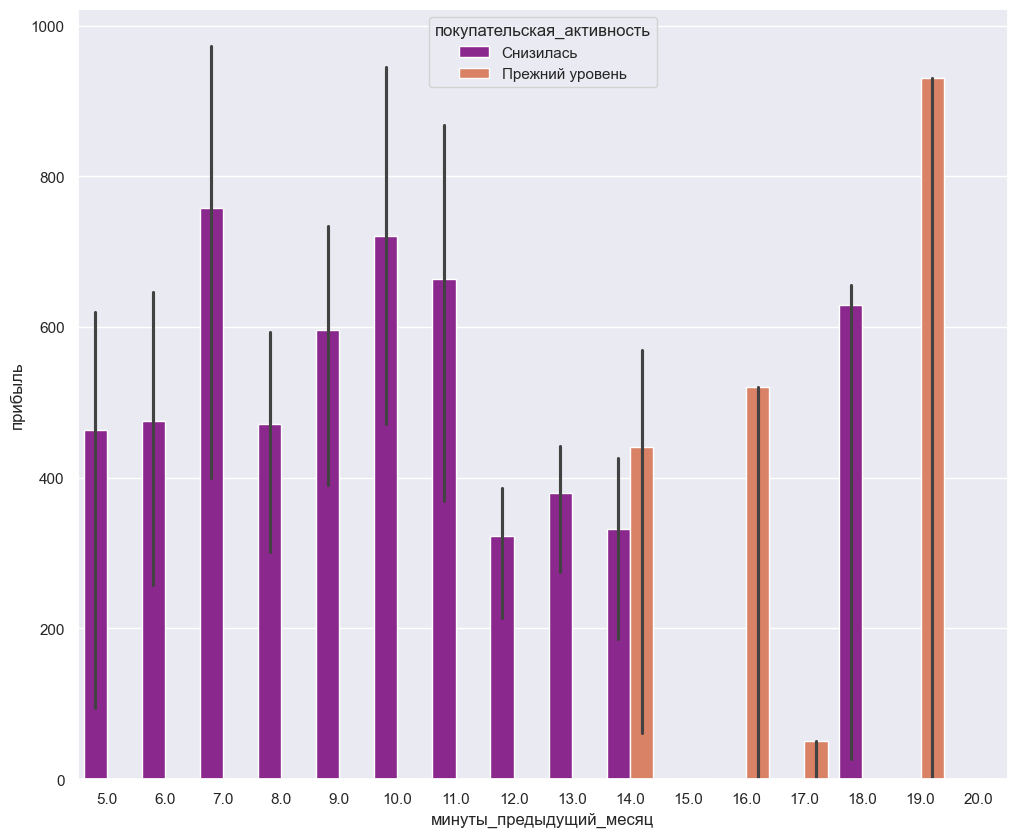

In [62]:
sns.barplot(x ='минуты_предыдущий_месяц', y ='прибыль', data = tagret_frame, 
            palette ='plasma', 
            hue ='покупательская_активность',
            estimator = np.std);

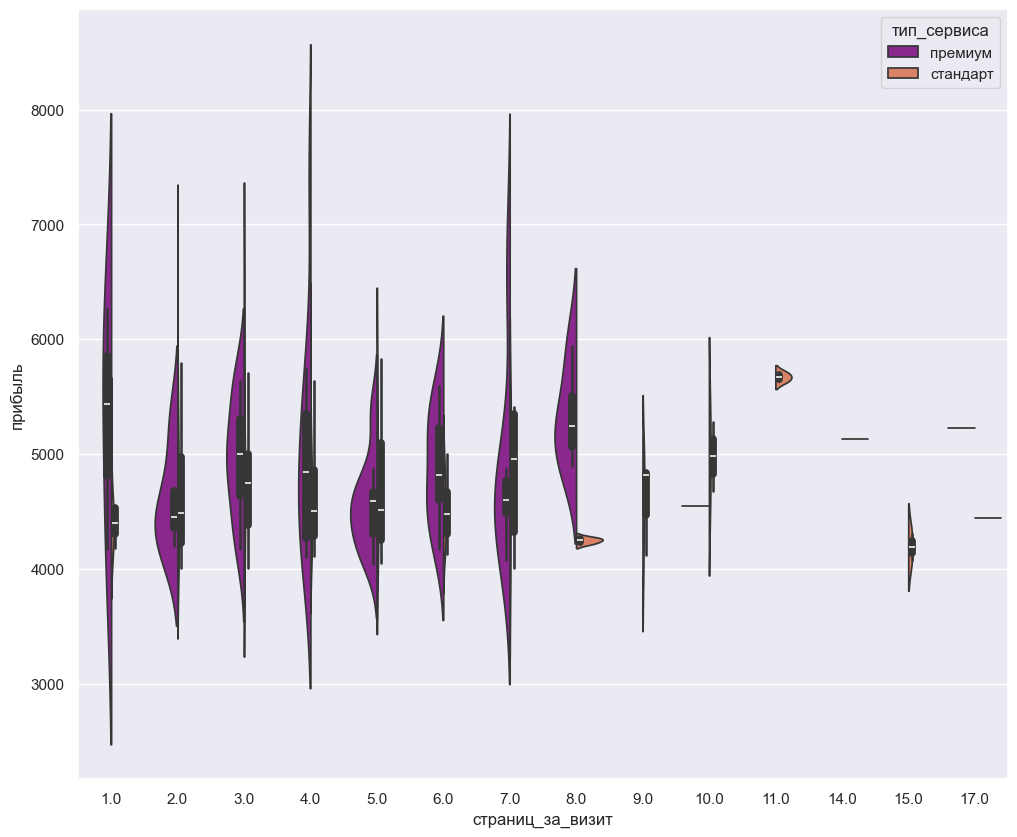

In [63]:
sns.violinplot(x='страниц_за_визит', y='прибыль', data=tagret_frame, hue='тип_сервиса', 
               palette='plasma', split=True);

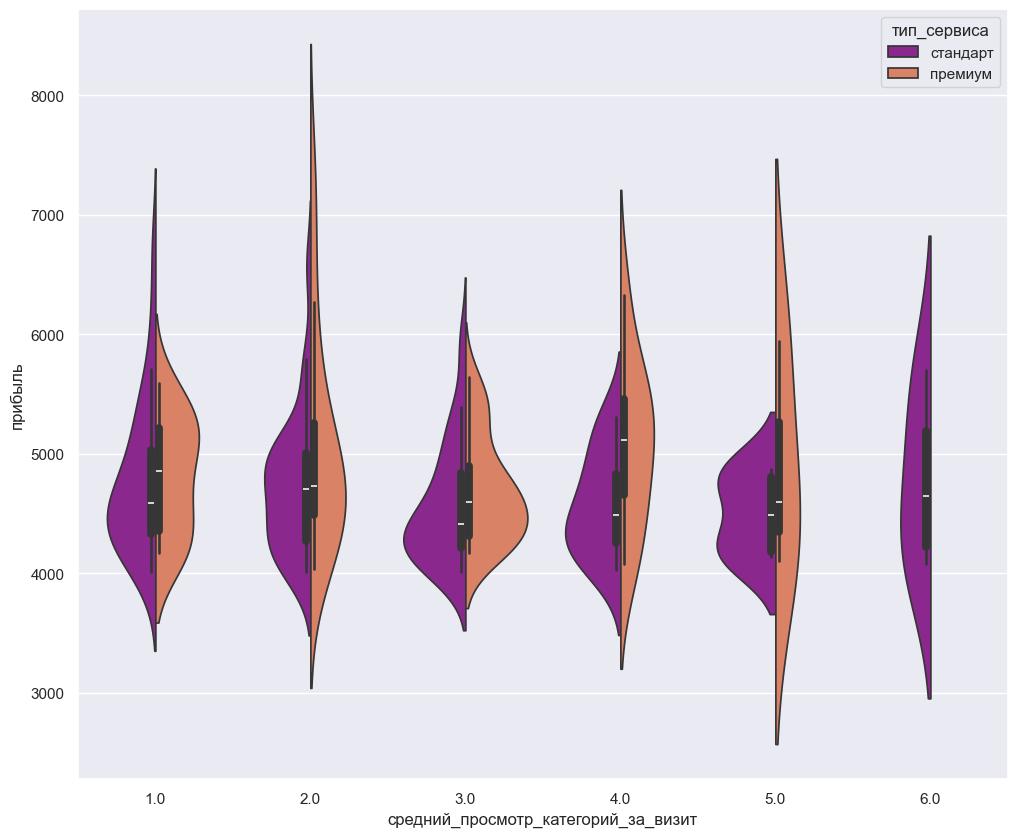

In [64]:
sns.violinplot(x='средний_просмотр_категорий_за_визит', y='прибыль', data=tagret_frame, hue='тип_сервиса', 
               palette='plasma', split=True);

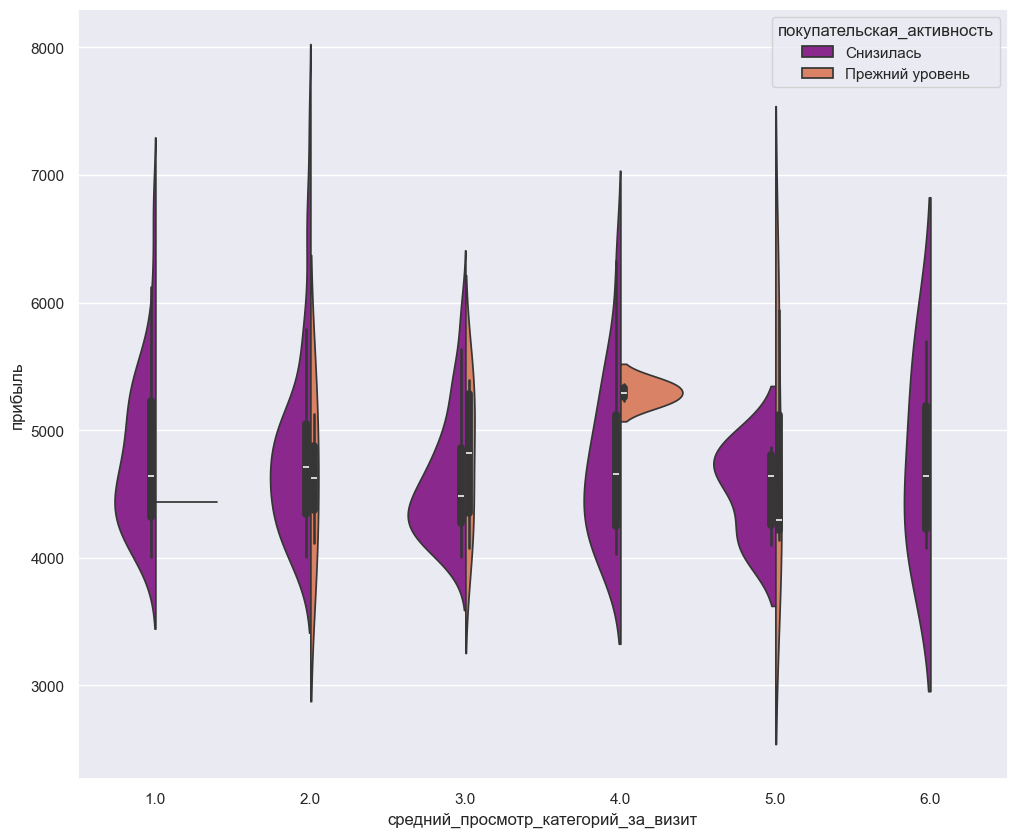

In [65]:
sns.violinplot(x='средний_просмотр_категорий_за_визит', y='прибыль', data=tagret_frame, hue='покупательская_активность', 
               palette='plasma', split=True);

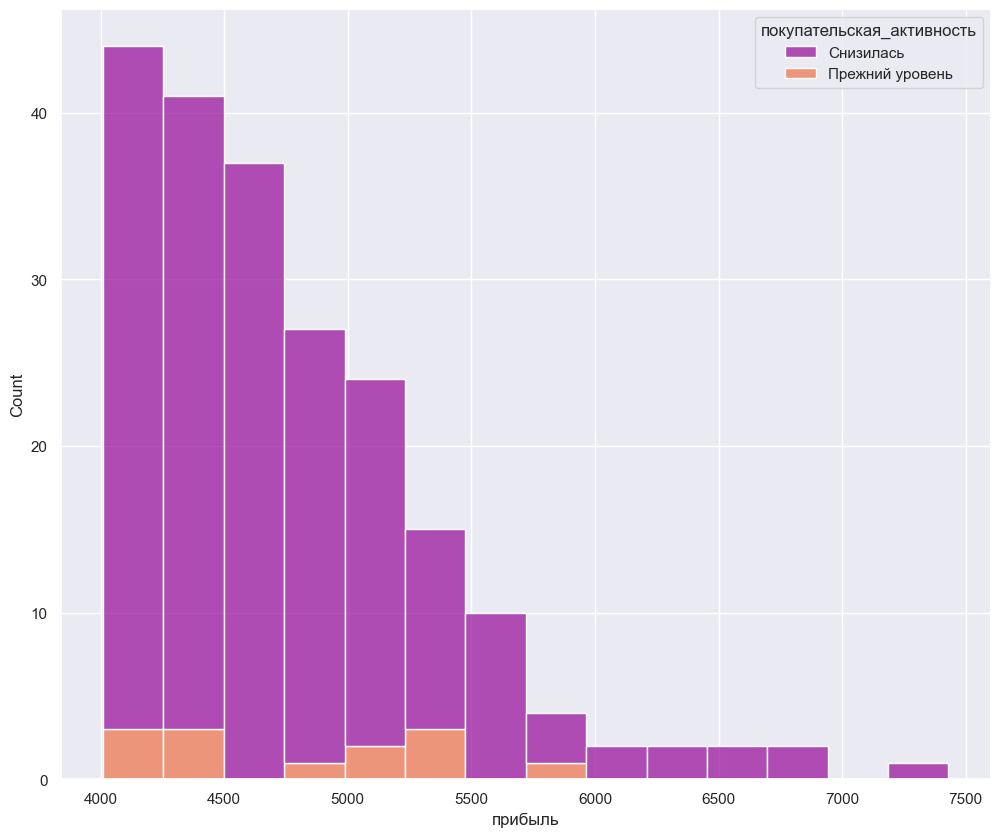

In [66]:
sns.histplot(data=tagret_frame, x='прибыль', hue='покупательская_активность', multiple='stack', palette='plasma');

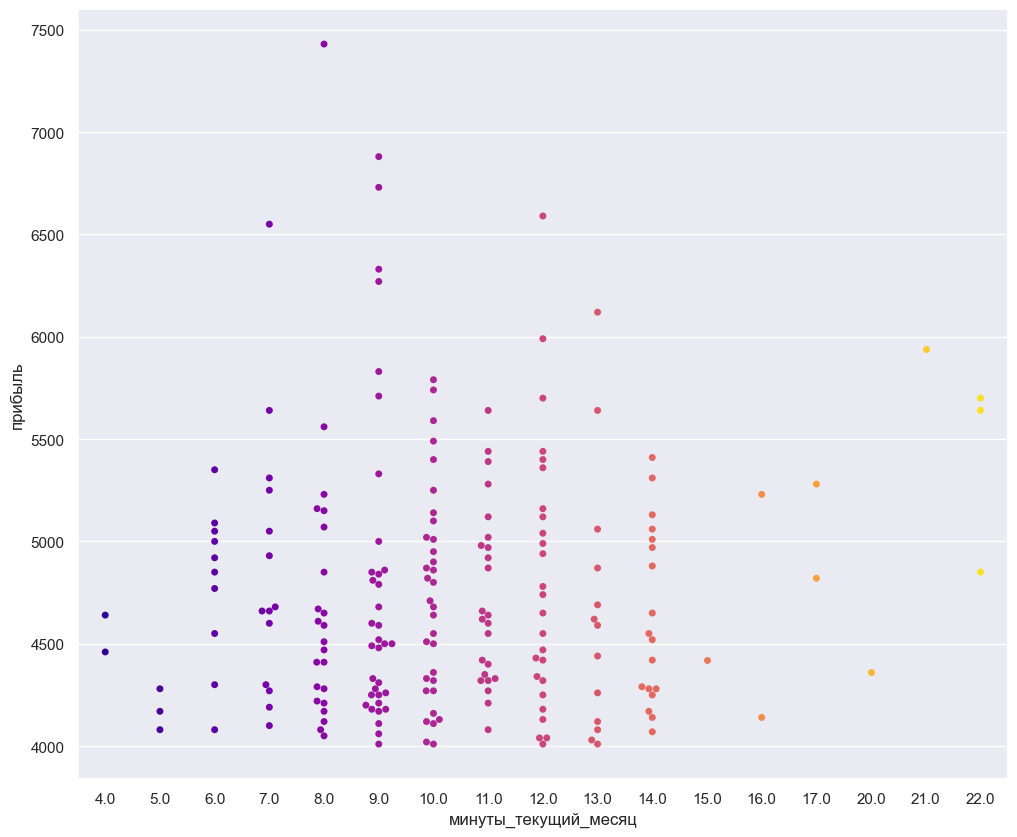

In [67]:
sns.swarmplot(x ='минуты_текущий_месяц', y ='прибыль', data=tagret_frame, palette='plasma');

## Выводы:
Для анализа выбран сегмент потребителей с высокой вероятностью снижения покупательской активности и высокой прибылью для компании (более 4000 руб) - 211 клиентов. Анализ сегмента позволяет сделать следующие выводы:

- нужно увеличивать время, проведенное на сайте
- нужно увеличивать долю премиум-клиентов и открывать больше страниц за визит - возможно, разработать специальные разделы с каталогом для клиентов премиум-уровня.
- уделить внимание в данном сегменте нужно клиентам с прибылью от 4 до 5,5 тыс рублей, как наиболее многочисленной группе сегмента.

## Общий вывод


Задачами был поиск лучшей модели, описывающей влияние признаков на снижение потребительской активности и выработка рекомендаций для бизнеса. В качестве исходных данных были: данныме о покупках клиентов, их предпочтениях, классе обслуживания, согласии на получение маркетинговых материалов, маркетинговой активности, доли акционных покупок, популярных категориях, поведении на сайте (оличестве страниц и категорий просмотра за визит, время на сайте, брошенные не оплаченные корзины, выручка и прибыль с клиента.
Для поиска лучшей модели был сделан пайплайн в котором перебирались модели (DecisionTreeClassifier, KNeighborsClassifier, SVC, LogisticRegression) и их гиперепараметры. В результате поиска с помощью метода GridSearchCV была выбрана оптимальная модель:
SVC(C=0.1, degree=1, random_state=42) с ядром 'rbf' и метрикой качества ROC-AUC (0.91).

На основании выбранной модели с помощью библиотеки shap было проанализировано влияние признаков на целевую переменную. Выяснилоась, что на снижение покупательской активности наиболее сильно влияют следующие признаки (по мере уменьшения значимости):
- страниц за визит - чем меньше страниц тем больше вероятность снижения активности
- минуты за предыдущий месяц, минты за текущий  - чем больше, тем меньше вероятность снижения активности
- доля акционных покупок - чем их меньше, тем меньше вероятность снижения активности
- минуты текущего сеанса - чем дольше на сайте, тем меньше вероятность снижения активности
- средний просмотр категорий за визит - чем их больше, тем меньше вероятность снижения активности
- неоплаченные продукты в квартал - чем их больше, тем больше вроятность снижения активности 
- маркетинговая активность за 6 месяцев - чем больше, тем меньше вероятность снижения актвности.

В качестве сегмента для кототорого даются рекомендации был выбран сегммент со снизившейся покупательской активностью и максимальным значением прибыли - высокодоходные и с высокой вероятностью снижения активности. В качестве границ берем вероятность снижения активности больше 0.6 и прибылью больше 4000 руб - 199 клиентов. 

Анализ сегмента позволил сделать следующие выводы:
- нужно увеличивать время, проведенное на сайте
- нужно увеличивать долю премиум-клиентов и открывать больше страниц за визит - возможно, разработать специальные разделы с каталогом для клиентов премиум-уровня.
- уделить внимание в данном сегменте нужно клиентам с прибылью от 4 до 5,5 тыс рублей, как наиболее многочисленной группе сегмента.